# Bloque II – Refinamiento y normalización  

In [67]:
import glob
import json
import os
from pathlib import Path
import re
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nltk.metrics.distance import edit_distance
from sentence_transformers import SentenceTransformer, util


import csv

import spacy
nlp = spacy.load("en_core_web_sm")

## Métricas

In [68]:
def normalizar_predicado(p):
    return p.replace("_", " ").lower().strip()

In [69]:
def evaluate_structural_similarity_ST(baseline_path, gold_path, threshold=0.8, verbose=False):
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device="cpu")

    def load_graph(filepath):
        df = pd.read_csv(filepath, sep=';')
        df['predicado'] = df['predicado'].apply(normalizar_predicado)
        nodes = set(df['sujeto']).union(df['objeto'])
        edges = set([tuple(x) for x in df[['sujeto', 'predicado', 'objeto']].values])
        return df, nodes, edges

    def map_entities(pred_entities, gold_entities, model, threshold=0.8):
        pred_list = list(pred_entities)
        gold_list = list(gold_entities)
        pred_emb = model.encode(pred_list, convert_to_tensor=True)
        gold_emb = model.encode(gold_list, convert_to_tensor=True)
        sim_matrix = util.pytorch_cos_sim(pred_emb, gold_emb)
        mapping = {}
        matches = []
        used_gold_nodes = set()
        for i, sims in enumerate(sim_matrix):
            best_score, best_j = sims.max(0)
            if best_score >= threshold:
                pred_term = pred_list[i]
                gold_term = gold_list[best_j.item()]
                if gold_term not in used_gold_nodes:
                    mapping[pred_term] = gold_term
                    used_gold_nodes.add(gold_term)
                    matches.append((pred_term, gold_term, float(best_score)))
                else:
                    mapping[pred_term] = pred_term
            else:
                mapping[pred_list[i]] = pred_list[i]
        return mapping, matches

    def map_edges(pred_edges, gold_edges, model, entity_mapping, threshold=0.8):
        mapped_edges = set()
        gold_edge_list = list(gold_edges)
        matches = []
        used_gold_edges = set()
        for s, p, o in pred_edges:
            s_m = entity_mapping.get(s, s)
            o_m = entity_mapping.get(o, o)
            p_emb = model.encode(p, convert_to_tensor=True)
            found = False
            for gold_s, gold_p, gold_o in gold_edge_list:
                if (gold_s, gold_p, gold_o) in used_gold_edges:
                    continue
                if entity_mapping.get(gold_s, gold_s) != s_m:
                    continue
                if entity_mapping.get(gold_o, gold_o) != o_m:
                    continue
                gold_p_emb = model.encode(gold_p, convert_to_tensor=True)
                sim = util.pytorch_cos_sim(p_emb, gold_p_emb).item()
                if sim >= threshold:
                    mapped_edges.add((s_m, gold_p, o_m))
                    used_gold_edges.add((gold_s, gold_p, gold_o))
                    matches.append(((s, p, o), (gold_s, gold_p, gold_o), float(sim)))
                    found = True
                    break
            if not found:
                mapped_edges.add((s_m, p, o_m))
        return mapped_edges, matches

    df_pred, nodes_pred, edges_pred = load_graph(baseline_path)
    df_gold, nodes_gold, edges_gold = load_graph(gold_path)

    if verbose:
        print("📥 Mapeando nodos...")

    node_mapping, node_matches = map_entities(nodes_pred, nodes_gold, model, threshold)

    if verbose:
        print("📥 Mapeando aristas...")

    mapped_edges, edge_matches = map_edges(edges_pred, edges_gold, model, node_mapping, threshold)
    mapped_nodes = {node_mapping[n] for n in nodes_pred}

    nodes_pred_set = set(mapped_nodes)
    nodes_gold_set = set(nodes_gold)
    edges_pred_set = set(mapped_edges)
    edges_gold_set = set(edges_gold)

    node_inter = nodes_pred_set & nodes_gold_set
    edge_inter = edges_pred_set & edges_gold_set
    node_union = nodes_pred_set | nodes_gold_set
    edge_union = edges_pred_set | edges_gold_set

    similarity = (len(node_inter) + len(edge_inter)) / (len(node_union) + len(edge_union)) if (len(node_union) + len(edge_union)) > 0 else 0.0

    if verbose:
        print("\n✅ Nodos mapeados (pred → gold):")
        for pred, gold, score in node_matches:
            print(f"  {pred} → {gold} (sim={score:.4f})")

        print("\n✅ Aristas mapeadas (pred → gold):")
        for pred_triple, gold_triple, score in edge_matches:
            print(f"  {pred_triple} → {gold_triple} (sim={score:.4f})")

        print(f"\n🧠 Nodos en común ({len(node_inter)}):")
        for n in node_inter:
            print(f"  ✔ {n}")

        print(f"\n➖ Nodos solo en pred ({len(nodes_pred_set - nodes_gold_set)}):")
        for n in nodes_pred_set - nodes_gold_set:
            print(f"  ✖ {n}")

        print(f"\n➖ Nodos solo en gold ({len(nodes_gold_set - nodes_pred_set)}):")
        for n in nodes_gold_set - nodes_pred_set:
            print(f"  ✖ {n}")

        print(f"\n🔗 Aristas en común ({len(edge_inter)}):")
        for e in edge_inter:
            print(f"  ✔ {e}")

        print(f"\n➖ Aristas solo en pred ({len(edges_pred_set - edges_gold_set)}):")
        for e in edges_pred_set - edges_gold_set:
            print(f"  ✖ {e}")

        print(f"\n➖ Aristas solo en gold ({len(edges_gold_set - edges_pred_set)}):")
        for e in edges_gold_set - edges_pred_set:
            print(f"  ✖ {e}")

        print(f"\n📊 Similitud estructural final: {similarity:.4f}")

    return {
      "nodos_en_comun": len(node_inter),
      "aristas_en_comun": len(edge_inter),
      "nodos_totales": len(node_union),
      "aristas_totales": len(edge_union),
      "similitud_estructural": similarity,
      "nodos_pred": nodes_pred_set,
      "nodos_gold": nodes_gold_set,
      "nodos_match": node_inter,
      "aristas_pred": edges_pred_set,
      "aristas_gold": edges_gold_set,
      "aristas_match": edge_inter,
  }

In [70]:
def evaluate_structural_similarity_levenshtein(baseline_path, gold_path, max_distance=2, verbose=False):
    def load_graph(filepath):
        df = pd.read_csv(filepath, sep=';')
        df['predicado'] = df['predicado'].apply(normalizar_predicado)
        nodes = set(df['sujeto']).union(df['objeto'])
        edges = set([tuple(x) for x in df[['sujeto', 'predicado', 'objeto']].values])
        return df, nodes, edges

    def map_entities(pred_entities, gold_entities, max_distance):
        mapping = {}
        matches = []
        used_gold = set()
        for pred in pred_entities:
            best_match = pred
            best_score = float('inf')
            for gold in gold_entities:
                dist = edit_distance(pred.lower(), gold.lower())
                if dist <= max_distance and dist < best_score and gold not in used_gold:
                    best_match = gold
                    best_score = dist
            mapping[pred] = best_match
            if best_match != pred:
                used_gold.add(best_match)
                matches.append((pred, best_match, best_score))
        return mapping, matches

    def map_edges(pred_edges, gold_edges, entity_mapping, max_distance):
        mapped_edges = set()
        used_gold_edges = set()
        matches = []
        for s, p, o in pred_edges:
            s_m = entity_mapping.get(s, s)
            o_m = entity_mapping.get(o, o)
            found = False
            for gs, gp, go in gold_edges:
                if gs != s_m or go != o_m or (gs, gp, go) in used_gold_edges:
                    continue
                dist = edit_distance(p.lower(), gp.lower())
                if dist <= max_distance:
                    mapped_edges.add((s_m, gp, o_m))
                    used_gold_edges.add((gs, gp, go))
                    matches.append(((s, p, o), (gs, gp, go), dist))
                    found = True
                    break
            if not found:
                mapped_edges.add((s_m, p, o_m))
        return mapped_edges, matches

    df_pred, nodes_pred, edges_pred = load_graph(baseline_path)
    df_gold, nodes_gold, edges_gold = load_graph(gold_path)

    if verbose:
        print("📥 Mapeando nodos...")

    node_mapping, node_matches = map_entities(nodes_pred, nodes_gold, max_distance)

    if verbose:
        print("📥 Mapeando aristas...")

    mapped_edges, edge_matches = map_edges(edges_pred, edges_gold, node_mapping, max_distance)
    mapped_nodes = {node_mapping[n] for n in nodes_pred}

    nodes_pred_set = set(mapped_nodes)
    nodes_gold_set = set(nodes_gold)
    edges_pred_set = set(mapped_edges)
    edges_gold_set = set(edges_gold)

    node_inter = nodes_pred_set & nodes_gold_set
    edge_inter = edges_pred_set & edges_gold_set
    node_union = nodes_pred_set | nodes_gold_set
    edge_union = edges_pred_set | edges_gold_set

    similarity = (len(node_inter) + len(edge_inter)) / (len(node_union) + len(edge_union)) if (len(node_union) + len(edge_union)) > 0 else 0.0

    if verbose:
        print("\n✅ Nodos mapeados (pred → gold):")
        for pred, gold, dist in node_matches:
            print(f"  {pred} → {gold} (dist={dist})")

        print("\n✅ Aristas mapeadas (pred → gold):")
        for pred_triple, gold_triple, dist in edge_matches:
            print(f"  {pred_triple} → {gold_triple} (dist={dist})")

        print(f"\n🧠 Nodos en común ({len(node_inter)}):")
        for n in node_inter:
            print(f"  ✔ {n}")

        print(f"\n➖ Nodos solo en pred ({len(nodes_pred_set - nodes_gold_set)}):")
        for n in nodes_pred_set - nodes_gold_set:
            print(f"  ✖ {n}")

        print(f"\n➖ Nodos solo en gold ({len(nodes_gold_set - nodes_pred_set)}):")
        for n in nodes_gold_set - nodes_pred_set:
            print(f"  ✖ {n}")

        print(f"\n🔗 Aristas en común ({len(edge_inter)}):")
        for e in edge_inter:
            print(f"  ✔ {e}")

        print(f"\n➖ Aristas solo en pred ({len(edges_pred_set - edges_gold_set)}):")
        for e in edges_pred_set - edges_gold_set:
            print(f"  ✖ {e}")

        print(f"\n➖ Aristas solo en gold ({len(edges_gold_set - edges_pred_set)}):")
        for e in edges_gold_set - edges_pred_set:
            print(f"  ✖ {e}")

        print(f"\n📊 Similitud estructural final: {similarity:.4f}")

    return {
      "nodos_en_comun": len(node_inter),
      "aristas_en_comun": len(edge_inter),
      "nodos_totales": len(node_union),
      "aristas_totales": len(edge_union),
      "similitud_estructural": similarity,
      "nodos_pred": nodes_pred_set,
      "nodos_gold": nodes_gold_set,
      "nodos_match": node_inter,
      "aristas_pred": edges_pred_set,
      "aristas_gold": edges_gold_set,
      "aristas_match": edge_inter,
  }

In [71]:
def calculate_accuracy_ST(gold_path, generated_path, threshold=0.8):
    results = evaluate_structural_similarity_ST(generated_path, gold_path, threshold)
    edge_accuracy = len(results["aristas_match"]) / len(results["aristas_pred"]) if results["aristas_pred"] else 0.0
    node_accuracy = len(results["nodos_match"]) / len(results["nodos_pred"]) if results["nodos_pred"] else 0.0
    return (edge_accuracy + node_accuracy) / 2

def calculate_recall_ST(gold_path, generated_path, threshold=0.8):
    results = evaluate_structural_similarity_ST(generated_path, gold_path, threshold)
    edge_recall = len(results["aristas_match"]) / len(results["aristas_gold"]) if results["aristas_gold"] else 0.0
    node_recall = len(results["nodos_match"]) / len(results["nodos_gold"]) if results["nodos_gold"] else 0.0
    return (edge_recall + node_recall) / 2

In [72]:
def calculate_accuracy_levenshtein(gold_path, generated_path, max_distance=2):
    results = evaluate_structural_similarity_levenshtein(generated_path, gold_path, max_distance)
    edge_accuracy = len(results["aristas_match"]) / len(results["aristas_pred"]) if results["aristas_pred"] else 0.0
    node_accuracy = len(results["nodos_match"]) / len(results["nodos_pred"]) if results["nodos_pred"] else 0.0
    return (edge_accuracy + node_accuracy) / 2

def calculate_recall_levenshtein(gold_path, generated_path, max_distance=2):
    results = evaluate_structural_similarity_levenshtein(generated_path, gold_path, max_distance)
    edge_recall = len(results["aristas_match"]) / len(results["aristas_gold"]) if results["aristas_gold"] else 0.0
    node_recall = len(results["nodos_match"]) / len(results["nodos_gold"]) if results["nodos_gold"] else 0.0
    return (edge_recall + node_recall) / 2

In [73]:
def evaluar_grafo(gold_path, generated_path, version_name, threshold_st=0.8, max_dist_lev=2):
    acc_st = calculate_accuracy_ST(gold_path, generated_path, threshold=threshold_st)
    recall_st = calculate_recall_ST(gold_path, generated_path, threshold=threshold_st)
    f1_st = (2 * acc_st * recall_st) / (acc_st + recall_st) if (acc_st + recall_st) > 0 else 0.0

    acc_lev = calculate_accuracy_levenshtein(gold_path, generated_path, max_distance=max_dist_lev)
    recall_lev = calculate_recall_levenshtein(gold_path, generated_path, max_distance=max_dist_lev)
    f1_lev = (2 * acc_lev * recall_lev) / (acc_lev + recall_lev) if (acc_lev + recall_lev) > 0 else 0.0

    jaccard_st = evaluate_structural_similarity_ST(generated_path, gold_path, threshold=threshold_st)["similitud_estructural"]
    jaccard_lev = evaluate_structural_similarity_levenshtein(generated_path, gold_path, max_distance=max_dist_lev)["similitud_estructural"]

    df = pd.DataFrame([{
        "versión": version_name,
        "accuracy_ST": acc_st,
        "accuracy_Levenshtein": acc_lev,
        "recall_ST": recall_st,
        "recall_Levenshtein": recall_lev,
        "f1_ST": f1_st,
        "f1_Levenshtein": f1_lev,
        "jaccard_ST": jaccard_st,
        "jaccard_Levenshtein": jaccard_lev
    }])

    return df


In [74]:
def plot_comparison_bars(df, title, colors=None):

    metrics = ["accuracy_ST", "accuracy_Levenshtein",
               "recall_ST", "recall_Levenshtein",
               "f1_ST", "f1_Levenshtein",
               "jaccard_ST", "jaccard_Levenshtein"]

    labels = ["Acc ST", "Acc Lev",
              "Rec ST", "Rec Lev",
              "F1 ST", "F1 Lev",
              "Jac ST", "Jac Lev"]

    versions = df["versión"].tolist()
    n_versions = len(versions)
    x = np.arange(len(metrics))
    width = 0.8 / n_versions

    default_colors = ['#ff7f0e', '#1f77b4', '#d62728', '#9467bd',
                      '#2ca02c', '#f0e442', '#e377c2', '#7f7f7f',
                      '#8c564b', '#17becf', '#bcbd22', '#393b79']

    if colors is None:
        colors = default_colors

    fig, ax = plt.subplots(figsize=(12, 6))
    for i, version in enumerate(versions):
        values = [df.loc[i, m] for m in metrics]
        positions = x - 0.4 + width/2 + i * width
        bars = ax.bar(
            positions, values, width,
            label=version,
            color=colors[i % len(colors)],
            edgecolor='black',
            alpha=0.85
        )
        for bar in bars:
            h = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, h + 0.01, f"{h:.2f}",
                    ha='center', va='bottom', fontsize=9)

    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=10, fontweight='medium', rotation=25)
    max_val = max(df[metrics].max())
    ax.set_ylim(0, max_val * 1.50)
    ax.set_ylabel("Metric Value", fontsize=12)
    ax.set_title(title, fontsize=14, pad=20)
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    ax.set_axisbelow(True)
    ax.legend(frameon=False, fontsize=11, loc='upper right')
    plt.tight_layout()
    plt.show()

## Estrategia 3: Corrección de verbos modales

Se transladan los modales (“can”, “may”, “should”, “will”, etc.) y sus complementos al propio predicado, y se descartan las tripletas que pierdan su objeto.

In [75]:
MODALS = {"can", "could", "may", "might", "should", "will", "would"}

def relocate_full(predicate: str, object_: str):
    if predicate.lower() not in MODALS:
        return predicate, object_
    doc = nlp(object_)
    tokens = list(doc)
    start = 1 if tokens and tokens[0].text.lower() == predicate.lower() else 0
    to_move = []
    for token in tokens[start:]:
        if token.pos_ in {"NOUN", "PROPN", "PRON", "DET", "NUM", "PUNCT"}:
            break
        to_move.append(token.text)
    if not to_move:
        return predicate, object_
    new_predicate = " ".join([predicate] + to_move)
    remainder = tokens[start + len(to_move):]
    new_object = " ".join(token.text for token in remainder).strip()
    return new_predicate, new_object

def transform_triplets(input_paths):
    for in_path in input_paths:
        base_dir = os.path.dirname(in_path)
        output_dir = os.path.join(base_dir, "Transformation_1_3")
        os.makedirs(output_dir, exist_ok=True)

        base_name = os.path.splitext(os.path.basename(in_path))[0]
        prefix = base_name.rsplit("_Transformation_1", 1)[0]
        new_name = f"{prefix}_Transformation_1_3.csv"
        out_path = os.path.join(output_dir, new_name)

        df = pd.read_csv(in_path, sep=";", quotechar='"')
        df_transformed = df.copy()

        print(f"\nProcesando {os.path.basename(in_path)}:")
        for idx, row in df.iterrows():
            orig_pred, orig_obj = row["predicado"], row["objeto"]
            new_pred, new_obj = relocate_full(orig_pred, orig_obj)

            if orig_pred != new_pred or orig_obj != new_obj:
                print(f"  Fila {idx}:")
                if orig_pred != new_pred:
                    print(f"    predicado: '{orig_pred}' → '{new_pred}'")
                if orig_obj != new_obj:
                    print(f"    objeto:    '{orig_obj}' → '{new_obj}'")

            df_transformed.at[idx, "predicado"] = new_pred
            df_transformed.at[idx, "objeto"]    = new_obj

        df_transformed = df_transformed[df_transformed["objeto"].str.strip().astype(bool)]
        df_transformed.to_csv(out_path, sep=";", index=False, quoting=csv.QUOTE_ALL)

        print(f"Transformed (filtered): {in_path} -> {out_path}")

paths = [
    "/content/Utilitarianism_Transformation_1.csv",
    "/content/Ellipse_Transformation_1.csv",
    "/content/Homeostasis_Transformation_1.csv",
    "/content/Inflation_Transformation_1.csv",
]
transform_triplets(paths)


Procesando Utilitarianism_Transformation_1.csv:
  Fila 4:
    predicado: 'can' → 'can discern'
    objeto:    'can discern' → ''
  Fila 6:
    predicado: 'can' → 'can discern throughout'
    objeto:    'can discern throughout history' → 'history'
  Fila 7:
    predicado: 'can' → 'can discern throughout'
    objeto:    'can discern throughout history of ethical theory' → 'history of ethical theory'
  Fila 8:
    predicado: 'can' → 'can discern throughout'
    objeto:    'can discern throughout history of theory' → 'history of theory'
  Fila 57:
    predicado: 'can' → 'can discern throughout'
    objeto:    'can discern throughout history of ethical theory' → 'history of ethical theory'
  Fila 58:
    predicado: 'can' → 'can discern'
    objeto:    'can discern' → ''
Transformed (filtered): /content/Utilitarianism_Transformation_1.csv -> /content/Transformation_1_3/Utilitarianism_Transformation_1_3.csv

Procesando Ellipse_Transformation_1.csv:
  Fila 0:
    predicado: 'can' → 'can also 

### Estrategia 3: Métricas

####  Análisis por texto




In [76]:
gold_paths = {
    "utilitarianism": "/content/Utilitarianism_Gold.csv",
    "ellipse": "/content/Ellipse_Gold.csv",
    "homeostasis": "/content/Homeostasis_Gold.csv",
    "inflation": "/content/Inflation_Gold.csv"
}
paths_t3 = {
    "utilitarianism": (
        "/content/Utilitarianism_Transformation_1.csv",
        "/content/Transformation_1_3/Utilitarianism_Transformation_1_3.csv"
    ),
    "ellipse": (
        "/content/Ellipse_Transformation_1.csv",
        "/content/Transformation_1_3/Ellipse_Transformation_1_3.csv"
    ),
    "homeostasis": (
        "/content/Homeostasis_Transformation_1.csv",
        "/content/Transformation_1_3/Homeostasis_Transformation_1_3.csv"
    ),
    "inflation": (
        "/content/Inflation_Transformation_1.csv",
        "/content/Transformation_1_3/Inflation_Transformation_1_3.csv"
    )
}

# 1) Utilitarianism
df_utilitarianism_t1_t3 = pd.concat([
    evaluar_grafo(gold_paths["utilitarianism"], paths_t3["utilitarianism"][0], "Transformación 1"),
    evaluar_grafo(gold_paths["utilitarianism"], paths_t3["utilitarianism"][1], "Transformaciones 1 + 3")
], ignore_index=True)

# 2) Ellipse
df_ellipse_t1_t3 = pd.concat([
    evaluar_grafo(gold_paths["ellipse"], paths_t3["ellipse"][0], "Transformación 1"),
    evaluar_grafo(gold_paths["ellipse"], paths_t3["ellipse"][1], "Transformaciones 1 + 3")
], ignore_index=True)

# 3) Homeostasis
df_homeostasis_t1_t3 = pd.concat([
    evaluar_grafo(gold_paths["homeostasis"], paths_t3["homeostasis"][0], "Transformación 1"),
    evaluar_grafo(gold_paths["homeostasis"], paths_t3["homeostasis"][1], "Transformaciones 1 + 3")
], ignore_index=True)

# 4) Inflation
df_inflation_t1_t3 = pd.concat([
    evaluar_grafo(gold_paths["inflation"], paths_t3["inflation"][0], "Transformación 1"),
    evaluar_grafo(gold_paths["inflation"], paths_t3["inflation"][1], "Transformaciones 1 + 3")
], ignore_index=True)

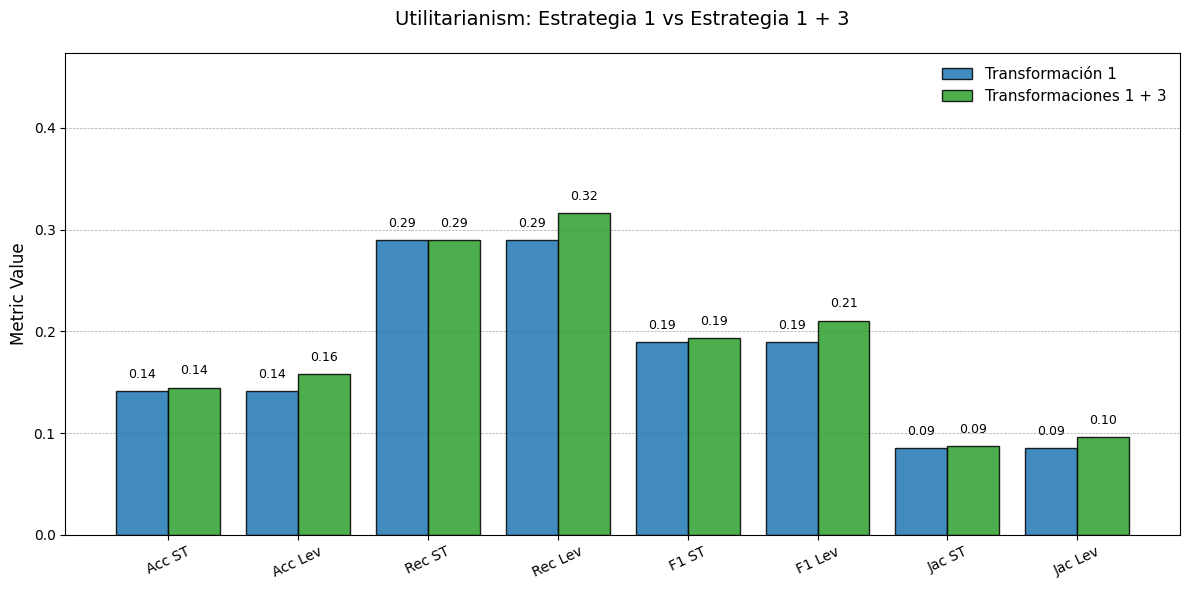

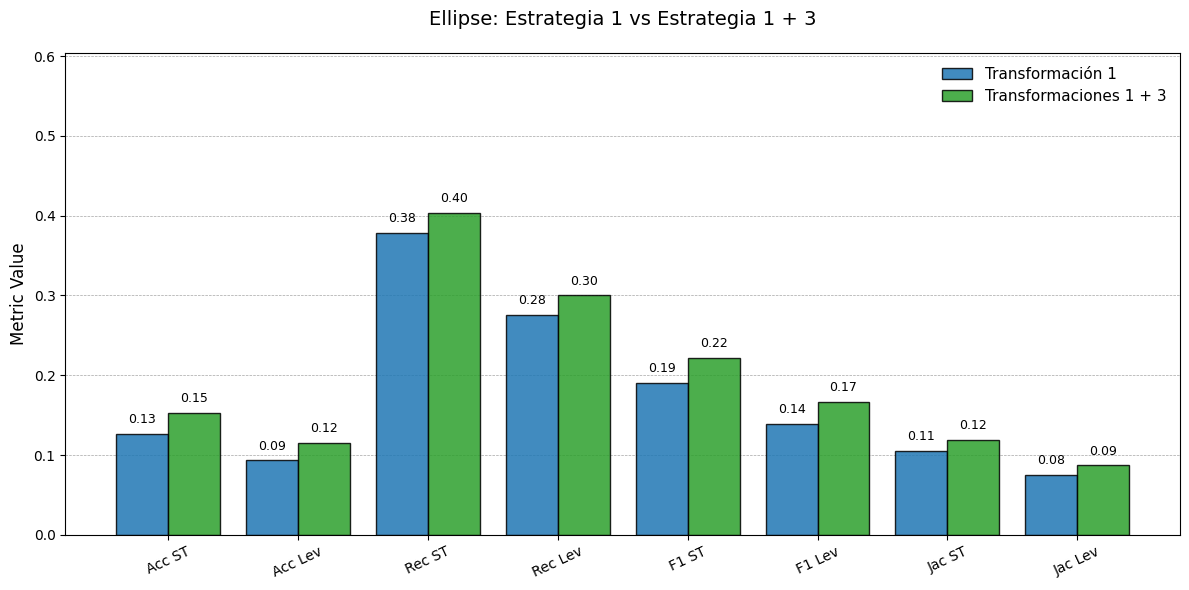

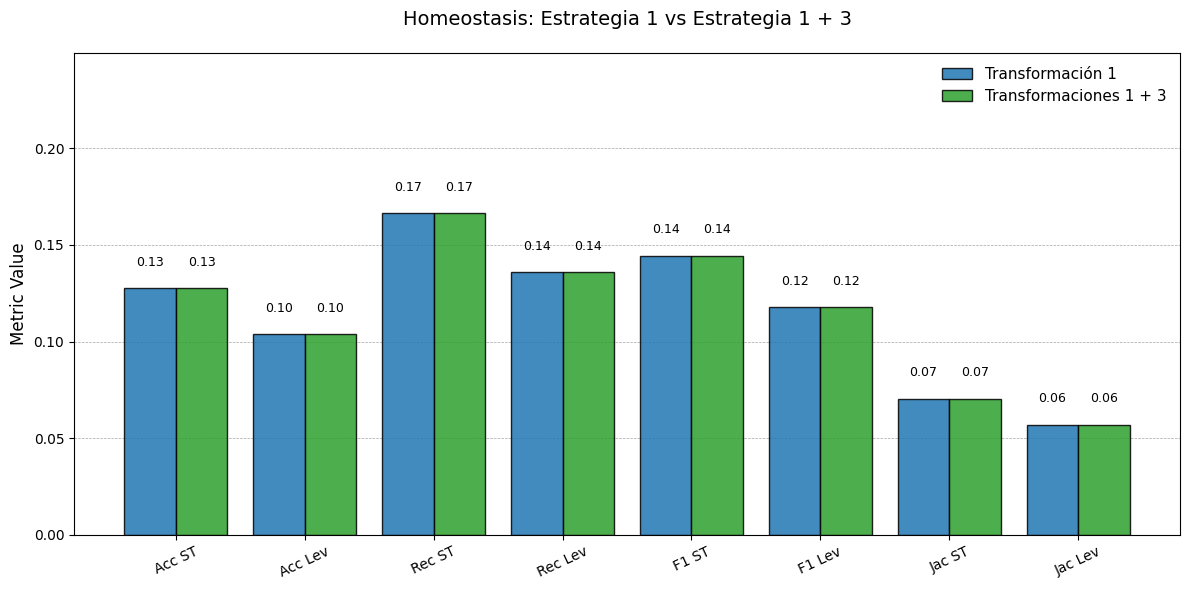

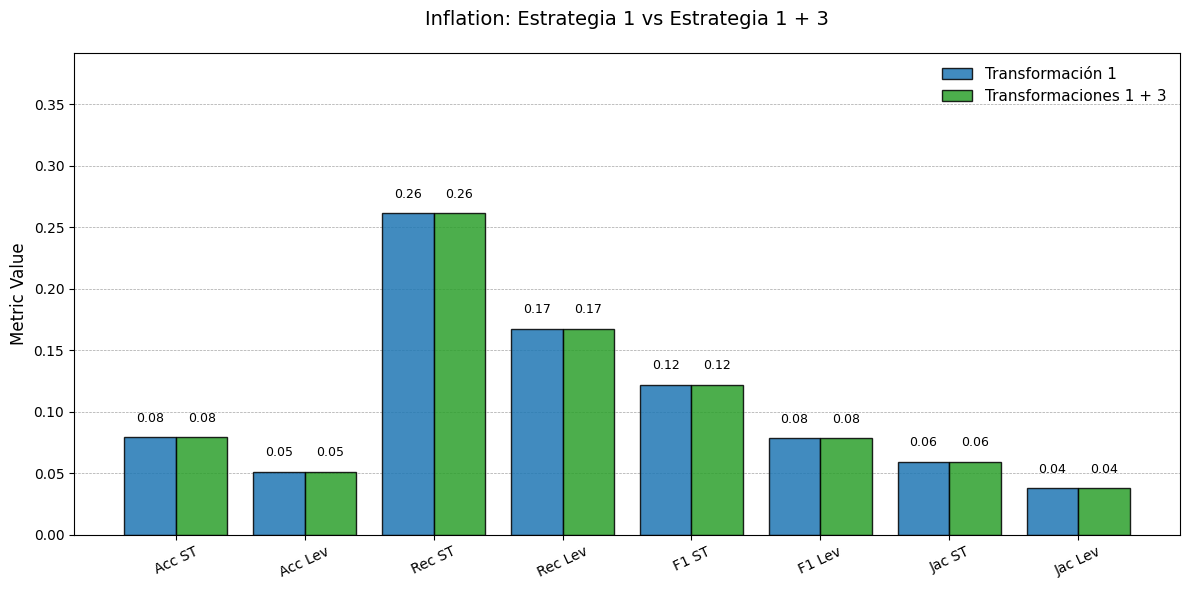

In [77]:
custom_colors = ['#1f77b4', '#2ca02c']

plot_comparison_bars(df_utilitarianism_t1_t3, "Utilitarianism: Estrategia 1 vs Estrategia 1 + 3", colors=custom_colors)
plot_comparison_bars(df_ellipse_t1_t3, "Ellipse: Estrategia 1 vs Estrategia 1 + 3", colors=custom_colors)
plot_comparison_bars(df_homeostasis_t1_t3, "Homeostasis: Estrategia 1 vs Estrategia 1 + 3", colors=custom_colors)
plot_comparison_bars(df_inflation_t1_t3, "Inflation: Estrategia 1 vs Estrategia 1 + 3", colors=custom_colors)

In [78]:
df_utilitarianism_t1_t3

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Transformación 1,0.141026,0.141026,0.289474,0.289474,0.189655,0.189655,0.085271,0.085271
1,Transformaciones 1 + 3,0.144737,0.157895,0.289474,0.315789,0.192982,0.210526,0.087302,0.096000


In [79]:
df_ellipse_t1_t3

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Transformación 1,0.126977,0.093220,0.377778,0.275,0.190069,0.139241,0.105634,0.075342
1,Transformaciones 1 + 3,0.152564,0.115385,0.402778,0.300,0.221303,0.166667,0.119403,0.086957


In [80]:
df_homeostasis_t1_t3

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Transformación 1,0.127668,0.103859,0.166221,0.135918,0.144416,0.117745,0.070513,0.056962
1,Transformaciones 1 + 3,0.127668,0.103859,0.166221,0.135918,0.144416,0.117745,0.070513,0.056962


In [81]:
df_inflation_t1_t3

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Transformación 1,0.079638,0.051336,0.261364,0.167614,0.122079,0.0786,0.059649,0.037801
1,Transformaciones 1 + 3,0.079638,0.051336,0.261364,0.167614,0.122079,0.0786,0.059649,0.037801


#### Evolución media de métricas

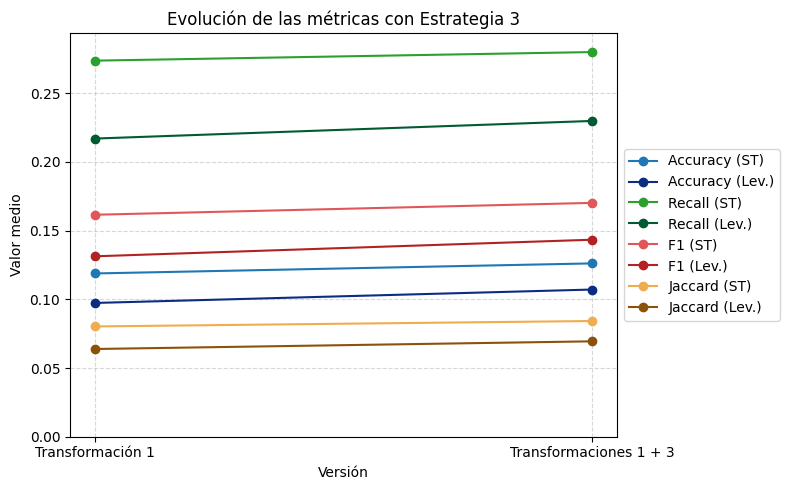

In [82]:
df_t1_t3_all = pd.concat([
    df_utilitarianism_t1_t3.assign(texto="Utilitarianism"),
    df_ellipse_t1_t3.assign(texto="Ellipse"),
    df_homeostasis_t1_t3.assign(texto="Homeostasis"),
    df_inflation_t1_t3.assign(texto="Inflation"),
], ignore_index=True)

df_t1_t3_summary = df_t1_t3_all.groupby("versión")[
    ["accuracy_ST","accuracy_Levenshtein",
     "recall_ST","recall_Levenshtein",
     "f1_ST", "f1_Levenshtein",
     "jaccard_ST","jaccard_Levenshtein"]
].mean().reset_index()

metrics = ["accuracy_ST","accuracy_Levenshtein",
     "recall_ST","recall_Levenshtein",
     "f1_ST", "f1_Levenshtein",
     "jaccard_ST","jaccard_Levenshtein"]

labels = [
    "Accuracy (ST)",
    "Accuracy (Lev.)",
    "Recall (ST)",
    "Recall (Lev.)",
    "F1 (ST)",
    "F1 (Lev.)",
    "Jaccard (ST)",
    "Jaccard (Lev.)"
]

color_map = {
    "accuracy_ST":          "#1f77b4",
    "accuracy_Levenshtein": "#0c2c84",
    "recall_ST":            "#2ca02c",
    "recall_Levenshtein":   "#005a32",
    "f1_ST":                "#e15759",
    "f1_Levenshtein":       "#B22222",
    "jaccard_ST":           "#f0ad4e",
    "jaccard_Levenshtein":  "#8c510a"
}


metrics = list(color_map.keys())

order=['Transformación 1', 'Transformaciones 1 + 3']
df_t1_t3_summary=df_t1_t3_summary.set_index('versión').loc[order].reset_index()

max_val = df_t1_t3_summary[metrics].max().max()

plt.figure(figsize=(8, 5))
for m, lbl in zip(metrics, labels):
    plt.plot(df_t1_t3_summary["versión"], df_t1_t3_summary[m], marker="o", label=lbl, color=color_map[m])

plt.ylim(0, max_val * 1.05)
plt.xlabel("Versión")
plt.ylabel("Valor medio")
plt.title("Evolución de las métricas con Estrategia 3")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [83]:
df_t1_t3_summary

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Transformación 1,0.118827,0.097360,0.273709,0.217001,0.161555,0.131310,0.080267,0.063844
1,Transformaciones 1 + 3,0.126152,0.107119,0.279959,0.229830,0.170195,0.143384,0.084217,0.069430


## 	Estrategia 4: Mapeo a chunks de CoreNLP  




Se mapean sujetos y objetos a los sintagmas extraídos por CoreNLP, a través de una comparación básica de lemas.

In [84]:
csv_files = [
    "/content/Utilitarianism_Transformation_1.csv",
    "/content/Ellipse_Transformation_1.csv",
    "/content/Homeostasis_Transformation_1.csv",
    "/content/Inflation_Transformation_1.csv",
]

In [85]:
def lemmatize(text):
    return [token.lemma_.lower() for token in nlp(text) if token.is_alpha]

def match_term_in_chunks(term, chunks):
    term_lemmas = set(lemmatize(term))
    best_chunk = None
    best_score = float('inf')
    for chunk in chunks:
        chunk_lemmas = set(lemmatize(chunk))
        if term_lemmas.issubset(chunk_lemmas):
            extras = len(chunk_lemmas - term_lemmas)
            if extras < best_score:
                best_score = extras
                best_chunk = chunk
    if best_chunk:
        return True, best_chunk
    return False, None

def map_triplets_to_chunks(csv_path, json_path, verbose=False):
    df = pd.read_csv(csv_path, sep=';')
    with open(json_path, 'r', encoding='latin-1') as f:
        data = json.load(f)
    sentence_to_chunks = {item['sentence']: item['concepts'] for item in data}
    df['chunks'] = df['frase'].apply(lambda x: sentence_to_chunks.get(x, []))

    chunk_subjects = []
    chunk_objects = []

    for _, row in df.iterrows():
        subject = row['sujeto']
        object_ = row['objeto']
        sentence = row['frase']
        chunks = row['chunks']

        subject_ok, chunk_subject = match_term_in_chunks(subject, chunks)
        object_ok, chunk_object = match_term_in_chunks(object_, chunks)

        chunk_subjects.append(chunk_subject if subject_ok else None)
        chunk_objects.append(chunk_object if object_ok else None)

        if verbose and (subject_ok or object_ok):
          print(f"✅ Mapeo exitoso: ({subject}, {row['predicado']}, {object_})")
          if subject_ok:
              print(f"  🟢 Sujeto: \"{subject}\" → \"{chunk_subject}\"")
          if object_ok:
              print(f"  🔵 Objeto: \"{object_}\" → \"{chunk_object}\"")
          print("-" * 60)

        if verbose and (not subject_ok or not object_ok):
            print(f"⚠️ Not fully mapped: ({subject}, {row['predicado']}, {object_})")
            if not subject_ok:
                print("  ↳ Subject not found in chunks.")
            if not object_ok:
                print("  ↳ Object not found in chunks.")
            print("-" * 60)

    df['chunk_sujeto'] = chunk_subjects
    df['chunk_objeto'] = chunk_objects
    df = df.drop(columns='chunks')

    return df

In [86]:
def save_triplets_with_chunks(df, output_path):
    df_out = pd.DataFrame()

    df_out['sujeto'] = df.apply(lambda row: row['chunk_sujeto'] if pd.notna(row['chunk_sujeto']) else row['sujeto'], axis=1)
    df_out['predicado'] = df['predicado']
    df_out['objeto'] = df.apply(lambda row: row['chunk_objeto'] if pd.notna(row['chunk_objeto']) else row['objeto'], axis=1)

    if 'confianza' in df.columns:
        df_out['confianza'] = df['confianza']
    if 'frase' in df.columns:
        df_out['frase'] = df['frase']

    output_dir = os.path.dirname(output_path)
    os.makedirs(output_dir, exist_ok=True)

    df_out.to_csv(output_path, sep=';', index=False, quoting=1, quotechar='"')
    print(f"✅ Saved: {output_path}")

In [87]:
for csv_path in csv_files:
    concept = csv_path.split("/")[-1].replace("_Transformation_1.csv", "")
    json_path = f"/content/VerbsAndConcepts/{concept}_VerbsAndConcepts.json"

    output_path = f"/content/Transformation_1_4/{concept}_Transformation_1_4.csv"

    print(f"🔄 Processing: {concept}")
    df_result = map_triplets_to_chunks(csv_path, json_path, verbose=True)
    save_triplets_with_chunks(df_result, output_path)

🔄 Processing: Utilitarianism
✅ Mapeo exitoso: (normative ethic, be in, history of philosophy)
  🟢 Sujeto: "normative ethic" → "normative ethics"
  🔵 Objeto: "history of philosophy" → "the history of philosophy"
------------------------------------------------------------
✅ Mapeo exitoso: (position, fully articulate until, century)
  🟢 Sujeto: "position" → "utilitarian positions"
  🔵 Objeto: "century" → "the 19th century"
------------------------------------------------------------
✅ Mapeo exitoso: (position, articulate until, century)
  🟢 Sujeto: "position" → "utilitarian positions"
  🔵 Objeto: "century" → "the 19th century"
------------------------------------------------------------
✅ Mapeo exitoso: (position, articulate until, 19th century)
  🟢 Sujeto: "position" → "utilitarian positions"
  🔵 Objeto: "19th century" → "the 19th century"
------------------------------------------------------------
✅ Mapeo exitoso: (position, can, can discern)
  🟢 Sujeto: "position" → "utilitarian posi

### Estrategia 4: Métricas

####  Análisis por texto

In [88]:
paths_t4 = {
    "utilitarianism": (
        "/content/Utilitarianism_Transformation_1.csv",
        "/content/Transformation_1_4/Utilitarianism_Transformation_1_4.csv"
    ),
    "ellipse": (
        "/content/Ellipse_Transformation_1.csv",
        "/content/Transformation_1_4/Ellipse_Transformation_1_4.csv"
    ),
    "homeostasis": (
        "/content/Homeostasis_Transformation_1.csv",
        "/content/Transformation_1_4/Homeostasis_Transformation_1_4.csv"
    ),
    "inflation": (
        "/content/Inflation_Transformation_1.csv",
        "/content/Transformation_1_4/Inflation_Transformation_1_4.csv"

    )
}

df_utilitarianism_t1_t4 = pd.concat([
    evaluar_grafo(gold_paths["utilitarianism"], paths_t4["utilitarianism"][0], "Transformación 1"),
    evaluar_grafo(gold_paths["utilitarianism"], paths_t4["utilitarianism"][1], "Transformaciones 1 + 4")
], ignore_index=True)

df_ellipse_t1_t4 = pd.concat([
    evaluar_grafo(gold_paths["ellipse"], paths_t4["ellipse"][0], "Transformación 1"),
    evaluar_grafo(gold_paths["ellipse"], paths_t4["ellipse"][1], "Transformaciones 1 + 4")
], ignore_index=True)

df_homeostasis_t1_t4 = pd.concat([
    evaluar_grafo(gold_paths["homeostasis"], paths_t4["homeostasis"][0], "Transformación 1"),
    evaluar_grafo(gold_paths["homeostasis"], paths_t4["homeostasis"][1], "Transformaciones 1 + 4")
], ignore_index=True)

df_inflation_t1_t4 = pd.concat([
    evaluar_grafo(gold_paths["inflation"], paths_t4["inflation"][0], "Transformación 1"),
    evaluar_grafo(gold_paths["inflation"], paths_t4["inflation"][1], "Transformaciones 1 + 4")
], ignore_index=True)

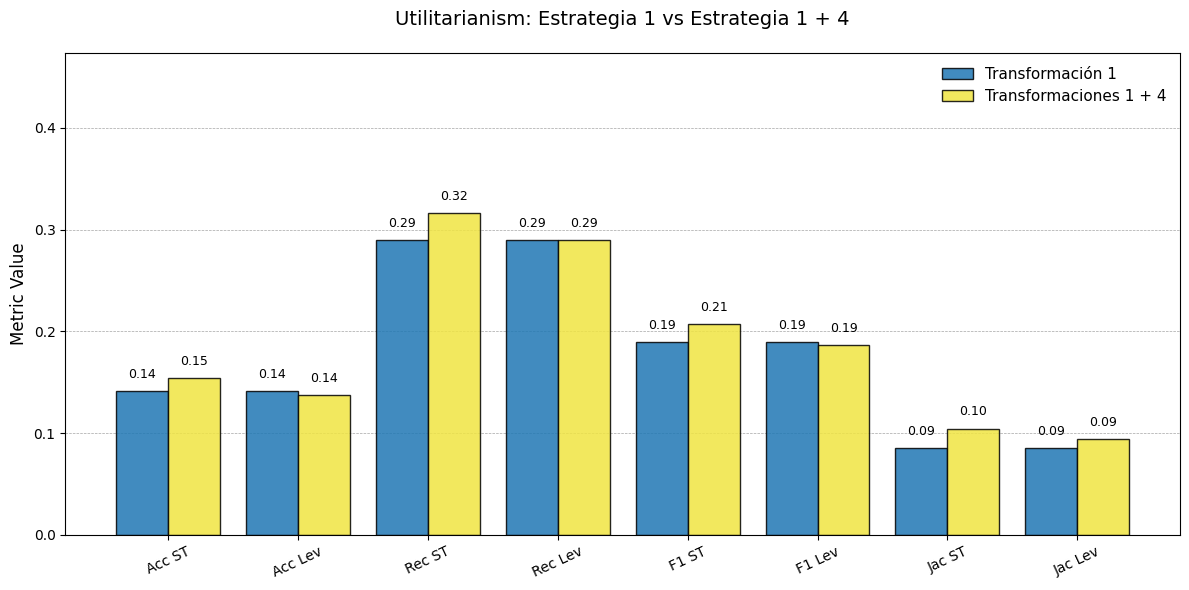

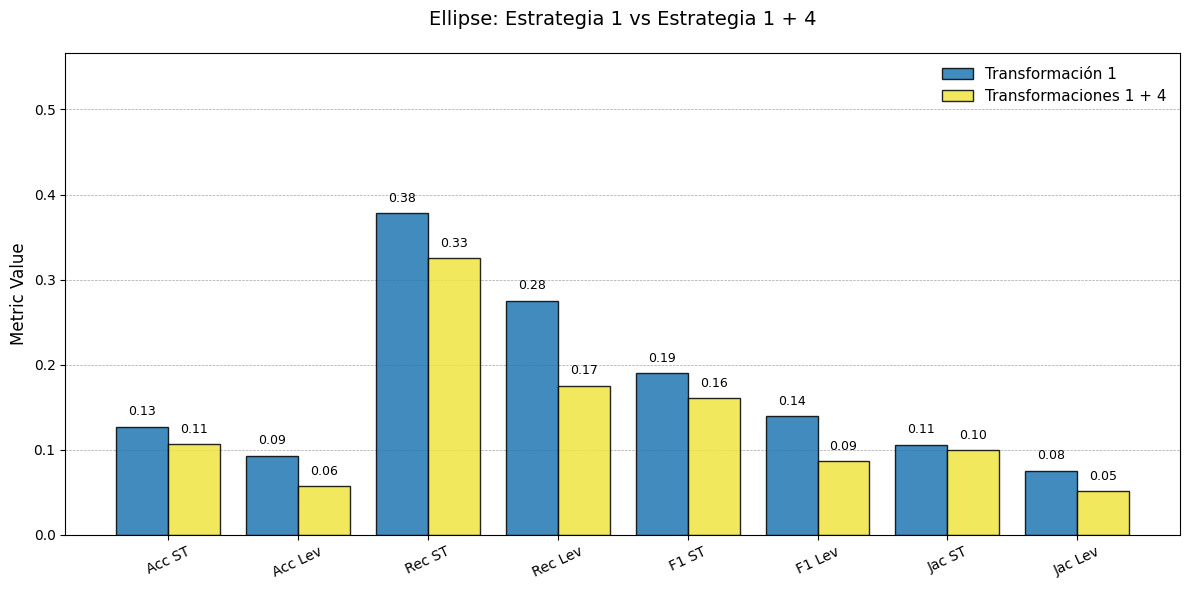

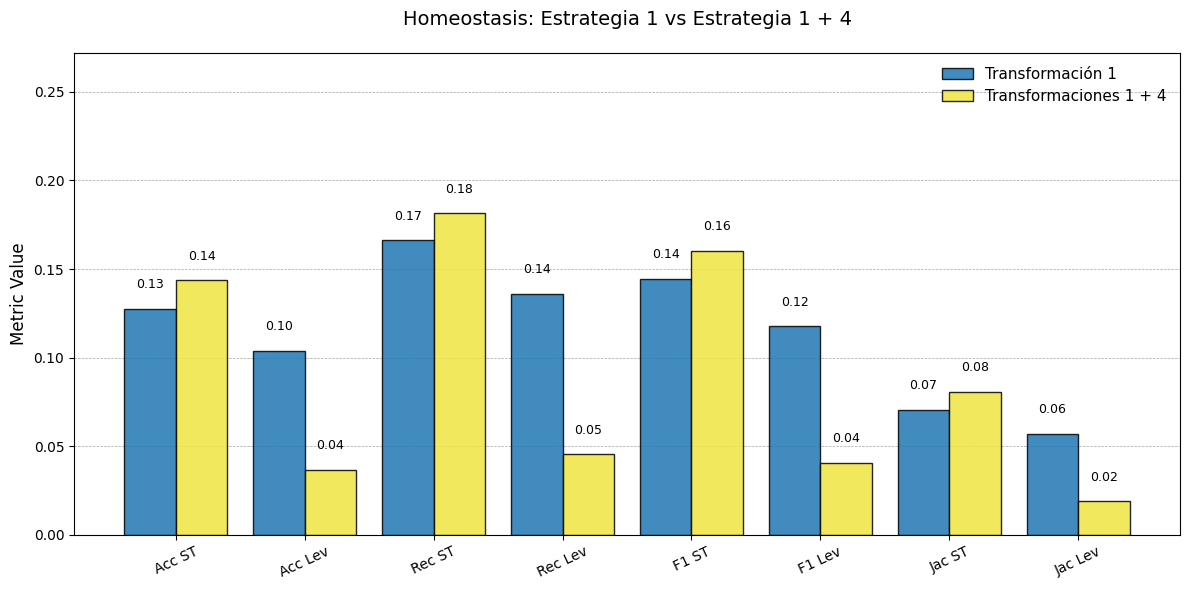

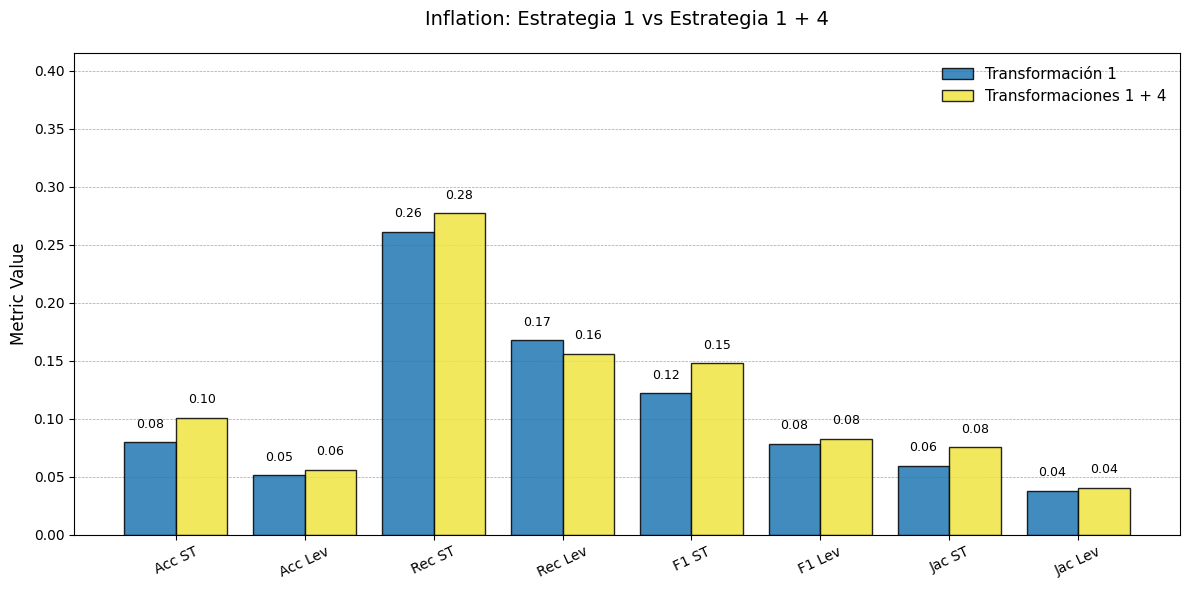

In [89]:
custom_colors = ['#1f77b4', '#f0e442']

plot_comparison_bars(df_utilitarianism_t1_t4, "Utilitarianism: Estrategia 1 vs Estrategia 1 + 4", colors=custom_colors)
plot_comparison_bars(df_ellipse_t1_t4, "Ellipse: Estrategia 1 vs Estrategia 1 + 4", colors=custom_colors)
plot_comparison_bars(df_homeostasis_t1_t4, "Homeostasis: Estrategia 1 vs Estrategia 1 + 4", colors=custom_colors)
plot_comparison_bars(df_inflation_t1_t4, "Inflation: Estrategia 1 vs Estrategia 1 + 4", colors=custom_colors)

In [90]:
df_utilitarianism_t1_t4

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Transformación 1,0.141026,0.141026,0.289474,0.289474,0.189655,0.189655,0.085271,0.085271
1,Transformaciones 1 + 4,0.153846,0.137500,0.315789,0.289474,0.206897,0.186441,0.104348,0.094017


In [91]:
df_ellipse_t1_t4

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Transformación 1,0.126977,0.093220,0.377778,0.275,0.190069,0.139241,0.105634,0.075342
1,Transformaciones 1 + 4,0.106557,0.057377,0.325000,0.175,0.160494,0.086420,0.099237,0.051095


In [92]:
df_homeostasis_t1_t4

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Transformación 1,0.127668,0.103859,0.166221,0.135918,0.144416,0.117745,0.070513,0.056962
1,Transformaciones 1 + 4,0.143580,0.036585,0.181373,0.045455,0.160279,0.040541,0.080537,0.018987


In [93]:
df_inflation_t1_t4

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Transformación 1,0.079638,0.051336,0.261364,0.167614,0.122079,0.078600,0.059649,0.037801
1,Transformaciones 1 + 4,0.101000,0.056180,0.276989,0.156250,0.148025,0.082645,0.075630,0.040650


#### Evolución media de métricas

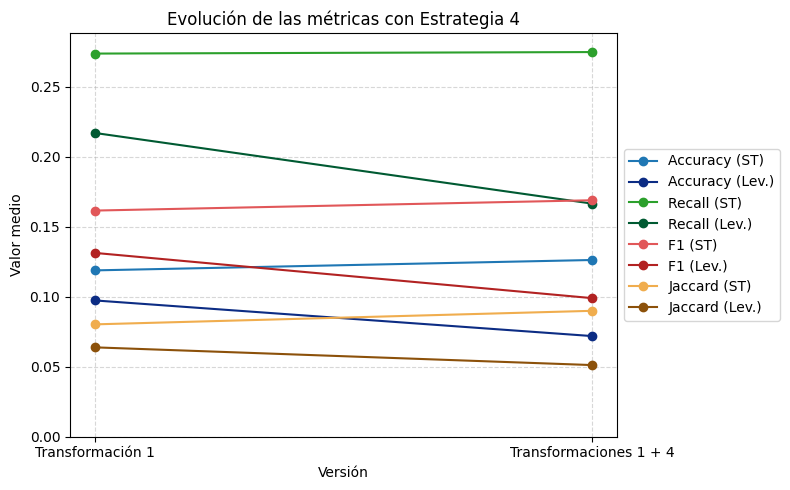

In [94]:
df_t1_t4_all = pd.concat([
    df_utilitarianism_t1_t4.assign(texto="Utilitarianism"),
    df_ellipse_t1_t4.assign(texto="Ellipse"),
    df_homeostasis_t1_t4.assign(texto="Homeostasis"),
    df_inflation_t1_t4.assign(texto="Inflation"),
], ignore_index=True)

df_t1_t4_summary = df_t1_t4_all.groupby("versión")[
    ["accuracy_ST","accuracy_Levenshtein",
     "recall_ST","recall_Levenshtein",
     "f1_ST", "f1_Levenshtein",
     "jaccard_ST","jaccard_Levenshtein"]
].mean().reset_index()

metrics = ["accuracy_ST","accuracy_Levenshtein",
     "recall_ST","recall_Levenshtein",
     "f1_ST", "f1_Levenshtein",
     "jaccard_ST","jaccard_Levenshtein"]
labels = [
    "Accuracy (ST)",
    "Accuracy (Lev.)",
    "Recall (ST)",
    "Recall (Lev.)",
    "F1 (ST)",
    "F1 (Lev.)",
    "Jaccard (ST)",
    "Jaccard (Lev.)"
]

order = ['Transformación 1', 'Transformaciones 1 + 4']
df_t1_t4_summary = df_t1_t4_summary.set_index('versión').loc[order].reset_index()

max_val = df_t1_t4_summary[metrics].max().max()

plt.figure(figsize=(8, 5))
for m, lbl in zip(metrics, labels):
    plt.plot(df_t1_t4_summary["versión"], df_t1_t4_summary[m], marker="o", label=lbl, color=color_map[m])

plt.ylim(0, max_val * 1.05)
plt.xlabel("Versión")
plt.ylabel("Valor medio")
plt.title("Evolución de las métricas con Estrategia 4")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [95]:
df_t1_t4_summary

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Transformación 1,0.118827,0.097360,0.273709,0.217001,0.161555,0.131310,0.080267,0.063844
1,Transformaciones 1 + 4,0.126246,0.071911,0.274788,0.166545,0.168924,0.099011,0.089938,0.051187


##	Estrategia 5: Chunks limpiados y enriquecidos (CoreNLP + SpaCy)  

1.	Filtrado de chunks excesivamente largos o con verbos
2.	Enriquecimiento con chunks de SpaCy
3.	Limpieza de stop words iniciales

In [96]:
def contains_verb(concept, verbs):
    doc = nlp(concept)
    tokens = {t.text.lower() for t in doc}
    return any(v.lower() in tokens for v in verbs)

def split_concepts_by_verb(input_path, output_path):
    try:
        with open(input_path, "r", encoding="utf-8") as f:
            data = json.load(f)
    except UnicodeDecodeError:
        with open(input_path, "r", encoding="latin-1") as f:
            data = json.load(f)
    print(f"Procesando {input_path}")
    for entry in data:
        concepts = entry.get("concepts", [])
        verbs    = entry.get("verbs", [])
        with_verbs, clean = [], []
        for c in concepts:
            if contains_verb(c, verbs):
                with_verbs.append(c)
            else:
                clean.append(c)
        entry["concepts_with_verbs"] = with_verbs
        entry["concepts"] = clean
    orig = Path(output_path)
    split_dir = orig.parent / "Split"
    split_dir.mkdir(parents=True, exist_ok=True)
    final = split_dir / orig.name
    with open(final, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)
    print(f"Guardado en {final}")

def enrich_file(file_path):
    p = Path(file_path)
    data = json.loads(p.read_text(encoding="utf-8"))
    out = p.parents[1] / "SplitSpacy"
    out.mkdir(parents=True, exist_ok=True)
    for entry in data:
        sentence = entry["sentence"]
        concepts = entry.get("concepts", [])
        existing = {c.lower().strip() for c in concepts}
        for chunk in nlp(sentence).noun_chunks:
            t = chunk.text
            if t.lower().strip() not in existing:
                concepts.append(t)
                existing.add(t.lower().strip())
        entry["concepts"] = concepts
    dest = out / f"{p.stem}_spacy.json"
    dest.write_text(json.dumps(data, ensure_ascii=False, indent=2), encoding="utf-8")
    print(f"Enriquecido y guardado en {dest}")
    return dest

def clean_chunk(chunk):
    doc = nlp(chunk)
    tokens = list(doc)
    i = 0
    while i < len(tokens) and tokens[i].is_stop:
        i += 1
    if i == len(tokens):
        return ""
    return " ".join(t.text for t in tokens[i:]).strip()

def clean_chunks(data, verbose=False, max_examples=5):
    count = 0
    for entry in data:
        original = entry.get("concepts", [])
        cleaned = [clean_chunk(c) for c in original if clean_chunk(c)]
        entry["concepts_cleaned"] = cleaned
        if verbose and count < max_examples:
            print("Oración:", entry["sentence"])
            print("Original:", original)
            print("Limpiado:", cleaned)
            count += 1
    return data

def clean_json(input_path, output_path, verbose=False):
    try:
        with open(input_path, "r", encoding="utf-8") as f:
            data = json.load(f)
    except UnicodeDecodeError:
        with open(input_path, "r", encoding="latin-1") as f:
            data = json.load(f)
    print(f"Limpieza de {input_path}")
    data = clean_chunks(data, verbose=verbose)
    orig = Path(output_path)
    cleaned_dir = orig.parent / "Cleaned"
    cleaned_dir.mkdir(parents=True, exist_ok=True)
    final = cleaned_dir / orig.name
    with open(final, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)
    print(f"Guardado limpio en {final}")

In [97]:
split_concepts_by_verb(
    "/content/VerbsAndConcepts/Utilitarianism_VerbsAndConcepts.json",
    "/content/Utilitarianism_concepts_split.json"
)
print('--------'*10)
split_concepts_by_verb(
    "/content/VerbsAndConcepts/Ellipse_VerbsAndConcepts.json",
    "/content/Ellipse_concepts_split.json"
)
print('--------'*10)
split_concepts_by_verb(
    "/content/VerbsAndConcepts/Homeostasis_VerbsAndConcepts.json",
    "/content/Homeostasis_concepts_split.json"
)
print('--------'*10)
split_concepts_by_verb(
    "/content/VerbsAndConcepts/Inflation_VerbsAndConcepts.json",
    "/content/Inflation_concepts_split.json"
)

print('-----------------'*10)

# Añadir chunks de Spacy
files = [
    "/content/Split/Utilitarianism_concepts_split.json",
    "/content/Split/Ellipse_concepts_split.json",
    "/content/Split/Homeostasis_concepts_split.json",
    "/content/Split/Inflation_concepts_split.json",
]
for fp in files:
  enrich_file(fp)
  print('--------'*10)

print('-----------------'*10)

clean_json(
    "/content/SplitSpacy/Utilitarianism_concepts_split_spacy.json",
    "/content/Utilitarianism_concepts_cleaned.json",
    verbose=True
)
print('--------'*10)
clean_json(
    "/content/SplitSpacy/Ellipse_concepts_split_spacy.json",
    "/content/Ellipse_concepts_cleaned.json",
    verbose=True
)
print('--------'*10)
clean_json(
    "/content/SplitSpacy/Homeostasis_concepts_split_spacy.json",
    "/content/Homeostasis_concepts_cleaned.json",
    verbose=True
)
print('--------'*10)
clean_json(
    "/content/SplitSpacy/Inflation_concepts_split_spacy.json",
    "/content/Inflation_concepts_cleaned.json",
    verbose=True
)

Procesando /content/VerbsAndConcepts/Utilitarianism_VerbsAndConcepts.json
Guardado en /content/Split/Utilitarianism_concepts_split.json
--------------------------------------------------------------------------------
Procesando /content/VerbsAndConcepts/Ellipse_VerbsAndConcepts.json
Guardado en /content/Split/Ellipse_concepts_split.json
--------------------------------------------------------------------------------
Procesando /content/VerbsAndConcepts/Homeostasis_VerbsAndConcepts.json
Guardado en /content/Split/Homeostasis_concepts_split.json
--------------------------------------------------------------------------------
Procesando /content/VerbsAndConcepts/Inflation_VerbsAndConcepts.json
Guardado en /content/Split/Inflation_concepts_split.json
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Enriquecido y guardado en /content/SplitSpacy/Utilitarianism_concepts_sp

Se mejora el mapeo para que sea más flexible:

In [98]:
def lemmatize(text):
    return [token.lemma_.lower() for token in nlp(text) if token.is_alpha]

def match_term_in_chunks(term, chunks):
    term_lemmas = set(lemmatize(term))

    # 1) Primer intento: coincidencia exacta
    for chunk in chunks:
        if set(lemmatize(chunk)) == term_lemmas:
            return True, chunk

    # 2) Segundo intento: subset (como antes)
    best_chunk = None
    best_score = float('inf')
    for chunk in chunks:
        lemmas = set(lemmatize(chunk))
        if term_lemmas.issubset(lemmas):
            extras = len(lemmas - term_lemmas)
            if extras < best_score:
                best_score = extras
                best_chunk = chunk
    if best_chunk:
        return True, best_chunk

    # 3) Tercer intento: máximo solapamiento de lemas (intersección)
    best_chunk = None
    best_overlap = 0
    for chunk in chunks:
        lemmas = set(lemmatize(chunk))
        overlap = len(term_lemmas & lemmas)
        if overlap > best_overlap:
            best_overlap = overlap
            best_chunk = chunk

    if best_overlap > 0:
        return True, best_chunk

    # 4) Si no hay ni un solo término en común, no mapeamos
    return False, None


def map_triplets_to_cleaned_chunks(csv_path, json_path, verbose=False):
    df = pd.read_csv(csv_path, sep=';')

    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except UnicodeDecodeError:
        with open(json_path, 'r', encoding='latin-1') as f:
            data = json.load(f)

    sentence_to_chunks = {
        item['sentence']: item.get('concepts_cleaned', [])
        for item in data
    }
    df['chunks'] = df['frase'].apply(lambda x: sentence_to_chunks.get(x, []))

    chunk_subjects = []
    chunk_objects = []

    for _, row in df.iterrows():
        subject = row['sujeto']
        object_ = row['objeto']
        chunks = row['chunks']

        if verbose:
            print(f"\n🔍 Frase: \"{row['frase']}\"")
            print("   ➤ Chunks disponibles:")
            for i, c in enumerate(chunks, 1):
                print(f"     {i}. \"{c}\"")
            if not chunks:
                print("     (ninguno)")

        subject_ok, chunk_subject = match_term_in_chunks(subject, chunks)
        object_ok, chunk_object = match_term_in_chunks(object_, chunks)

        chunk_subjects.append(chunk_subject if subject_ok else None)
        chunk_objects.append(chunk_object if object_ok else None)

        if verbose:
            if subject_ok or object_ok:
                print(f"✅ Mapeo exitoso: ({subject}, {row['predicado']}, {object_})")
                if subject_ok:
                    print(f"  🟢 Sujeto: \"{subject}\" → \"{chunk_subject}\"")
                if object_ok:
                    print(f"  🔵 Objeto: \"{object_}\" → \"{chunk_object}\"")
            else:
                print(f"⚠️ No se mapeó completamente: ({subject}, {row['predicado']}, {object_})")
                print("  ↳ Subject not found in cleaned chunks." if not subject_ok else "")
                print("  ↳ Object not found in cleaned chunks." if not object_ok else "")
            print("-" * 60)

    df['chunk_sujeto'] = chunk_subjects
    df['chunk_objeto'] = chunk_objects
    df = df.drop(columns='chunks')

    return df

In [99]:
csv_files = [
    "/content/Utilitarianism_Transformation_1.csv",
    "/content/Ellipse_Transformation_1.csv",
    "/content/Homeostasis_Transformation_1.csv",
    "/content/Inflation_Transformation_1.csv",

]

for csv_path in csv_files:
    concept = csv_path.split("/")[-1].replace("_Transformation_1.csv", "")
    json_path = f"/content/Cleaned/{concept}_concepts_cleaned.json"
    output_path = f"/content/Transformation_1_5/{concept}_Transformation_1_5.csv"

    print(f"🔄 Processing (Transformation_1_5): {concept}")
    df_result = map_triplets_to_cleaned_chunks(csv_path, json_path, verbose=True)
    save_triplets_with_chunks(df_result, output_path)

🔄 Processing (Transformation_1_5): Utilitarianism

🔍 Frase: "Utilitarianism is one of the most powerful and persuasive approaches to normative ethics in the history of philosophy."
   ➤ Chunks disponibles:
     1. "Utilitarianism"
     2. "normative ethics"
     3. "normative ethics in the history of philosophy"
     4. "powerful and persuasive approaches to normative ethics in the history of philosophy"
     5. "philosophy"
     6. "history"
     7. "history of philosophy"
     8. "powerful and persuasive approaches"
     9. "powerful and persuasive approaches to normative ethics in the history of philosophy"
✅ Mapeo exitoso: (normative ethic, be in, history of philosophy)
  🟢 Sujeto: "normative ethic" → "normative ethics"
  🔵 Objeto: "history of philosophy" → "history of philosophy"
------------------------------------------------------------

🔍 Frase: "Though not fully articulated until the 19th century, proto-utilitarian positions can be discerned throughout the history of ethical 

### Estrategia 5: Métricas

#### Análisis por texto

In [100]:
paths_t5 = {
    "utilitarianism": (
        "/content/Utilitarianism_Transformation_1.csv",
        "/content/Transformation_1_5/Utilitarianism_Transformation_1_5.csv"
    ),
    "ellipse": (
        "/content/Ellipse_Transformation_1.csv",
        "/content/Transformation_1_5/Ellipse_Transformation_1_5.csv"
    ),
    "homeostasis": (
        "/content/Homeostasis_Transformation_1.csv",
        "/content/Transformation_1_5/Homeostasis_Transformation_1_5.csv"
    ),
    "inflation": (
        "/content/Inflation_Transformation_1.csv",
        "/content/Transformation_1_5/Inflation_Transformation_1_5.csv"
    )
}

df_utilitarianism_t1_t5 = pd.concat([
    evaluar_grafo(gold_paths["utilitarianism"], paths_t5["utilitarianism"][0], "Transformación 1"),
    evaluar_grafo(gold_paths["utilitarianism"], paths_t5["utilitarianism"][1], "Transformaciones 1 + 5")
], ignore_index=True)

df_ellipse_t1_t5 = pd.concat([
    evaluar_grafo(gold_paths["ellipse"], paths_t5["ellipse"][0], "Transformación 1"),
    evaluar_grafo(gold_paths["ellipse"], paths_t5["ellipse"][1], "Transformaciones 1 + 5")
], ignore_index=True)

df_homeostasis_t1_t5 = pd.concat([
    evaluar_grafo(gold_paths["homeostasis"], paths_t5["homeostasis"][0], "Transformación 1"),
    evaluar_grafo(gold_paths["homeostasis"], paths_t5["homeostasis"][1], "Transformaciones 1 + 5")
], ignore_index=True)

df_inflation_t1_t5 = pd.concat([
    evaluar_grafo(gold_paths["inflation"], paths_t5["inflation"][0], "Transformación 1"),
    evaluar_grafo(gold_paths["inflation"], paths_t5["inflation"][1], "Transformaciones 1 + 5")
], ignore_index=True)

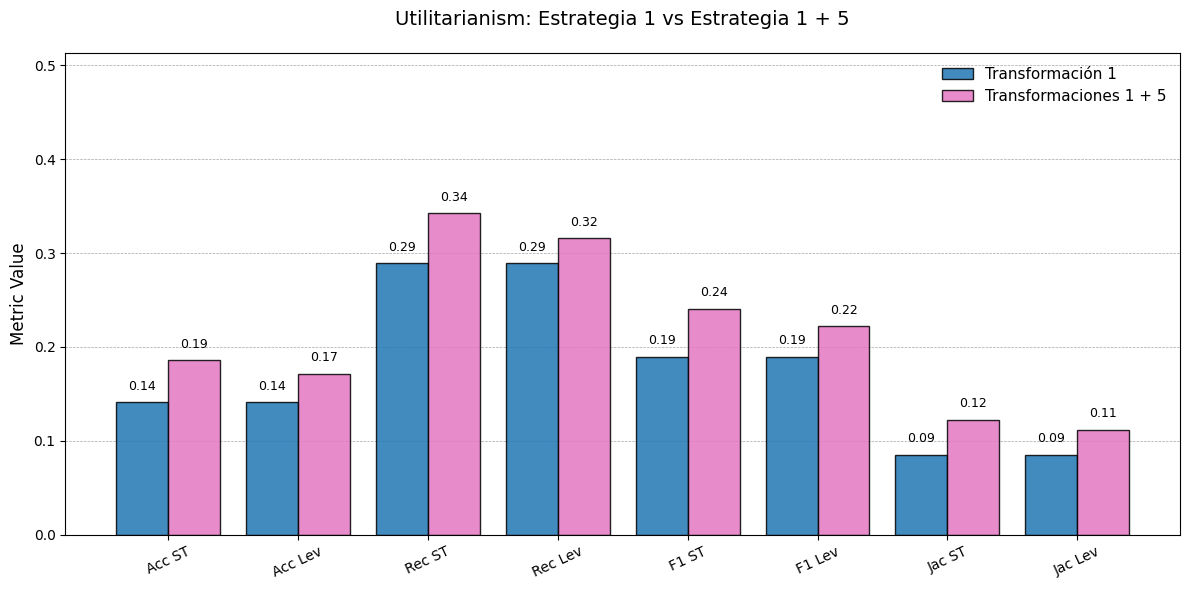

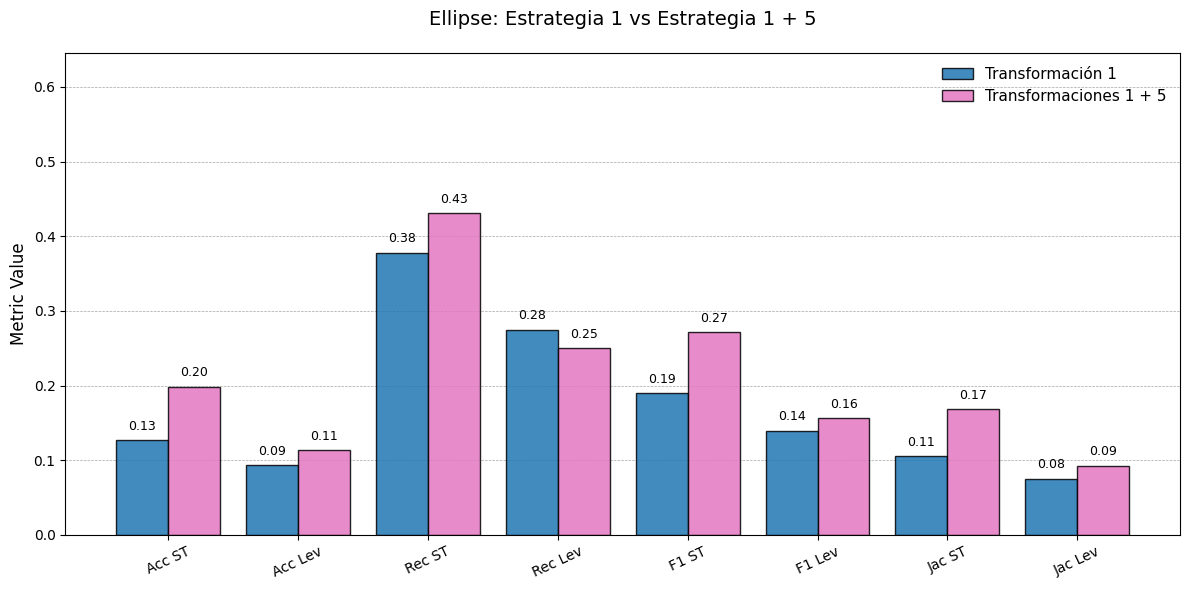

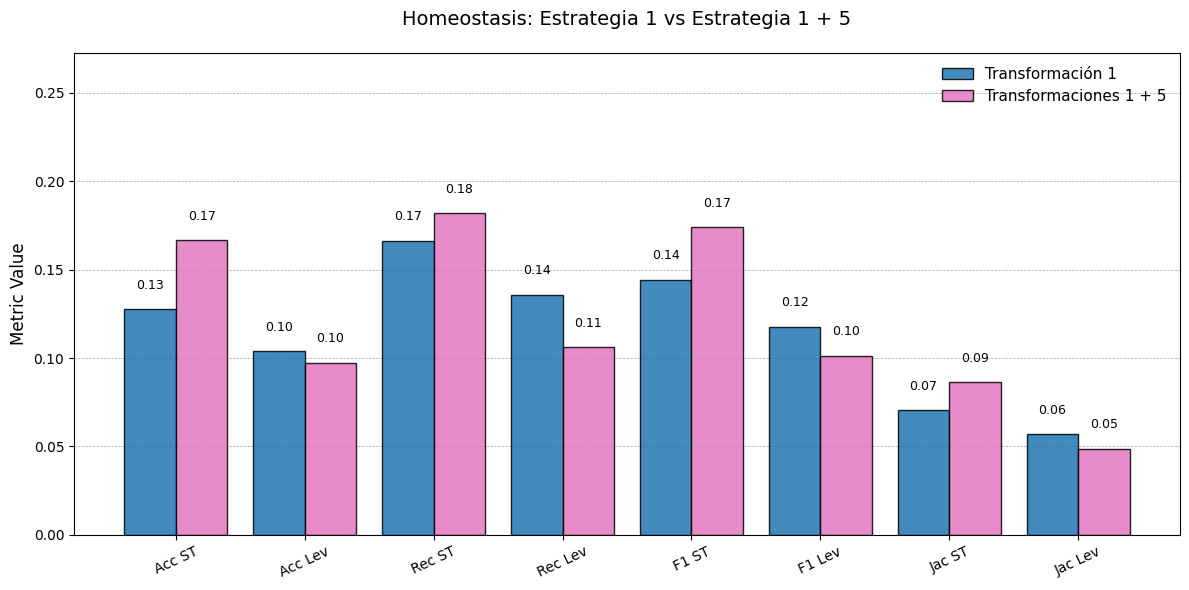

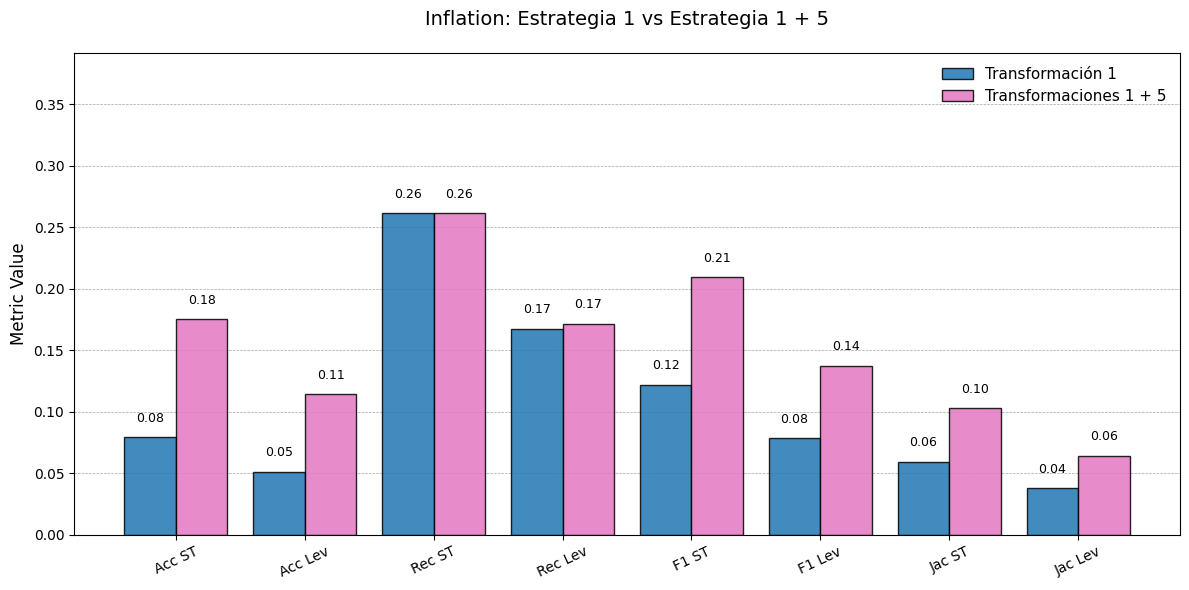

In [101]:
custom_colors = ['#1f77b4', '#e377c2']

plot_comparison_bars(df_utilitarianism_t1_t5, "Utilitarianism: Estrategia 1 vs Estrategia 1 + 5", colors=custom_colors)
plot_comparison_bars(df_ellipse_t1_t5, "Ellipse: Estrategia 1 vs Estrategia 1 + 5", colors=custom_colors)
plot_comparison_bars(df_homeostasis_t1_t5, "Homeostasis: Estrategia 1 vs Estrategia 1 + 5", colors=custom_colors)
plot_comparison_bars(df_inflation_t1_t5, "Inflation: Estrategia 1 vs Estrategia 1 + 5", colors=custom_colors)

In [102]:
df_utilitarianism_t1_t5

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Transformación 1,0.141026,0.141026,0.289474,0.289474,0.189655,0.189655,0.085271,0.085271
1,Transformaciones 1 + 5,0.185714,0.171429,0.342105,0.315789,0.240741,0.222222,0.122642,0.112150


In [103]:
df_ellipse_t1_t5

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Transformación 1,0.126977,0.093220,0.377778,0.275,0.190069,0.139241,0.105634,0.075342
1,Transformaciones 1 + 5,0.198232,0.113636,0.430556,0.250,0.271475,0.156250,0.168317,0.092593


In [104]:
df_homeostasis_t1_t5

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Transformación 1,0.127668,0.103859,0.166221,0.135918,0.144416,0.117745,0.070513,0.056962
1,Transformaciones 1 + 5,0.166667,0.097222,0.181818,0.106061,0.173913,0.101449,0.086331,0.048611


In [105]:
df_inflation_t1_t5

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Transformación 1,0.079638,0.051336,0.261364,0.167614,0.122079,0.0786,0.059649,0.037801
1,Transformaciones 1 + 5,0.175287,0.114583,0.261364,0.171875,0.209841,0.1375,0.103030,0.064327


#### Evolución media de métricas

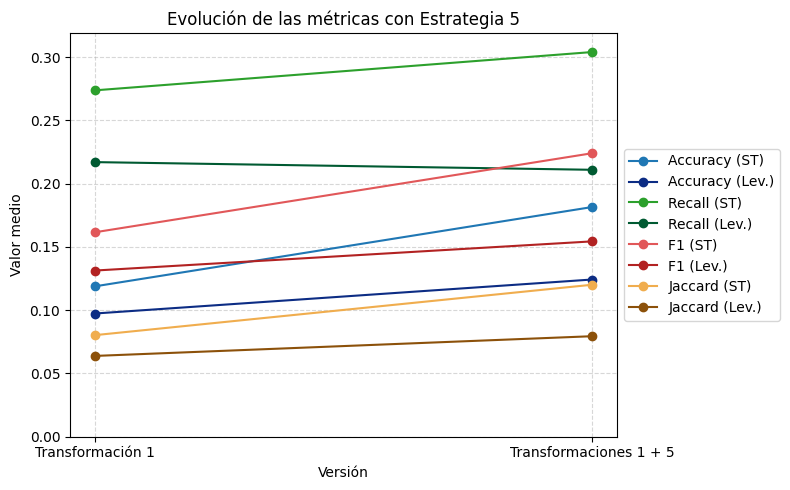

In [106]:
df_t1_t5_all = pd.concat([
    df_utilitarianism_t1_t5.assign(texto="Utilitarianism"),
    df_ellipse_t1_t5.assign(texto="Ellipse"),
    df_homeostasis_t1_t5.assign(texto="Homeostasis"),
    df_inflation_t1_t5.assign(texto="Inflation"),
], ignore_index=True)

df_t1_t5_summary = df_t1_t5_all.groupby("versión")[
    ["accuracy_ST","accuracy_Levenshtein",
     "recall_ST","recall_Levenshtein",
     "f1_ST", "f1_Levenshtein",
     "jaccard_ST","jaccard_Levenshtein"]
].mean().reset_index()

metrics = ["accuracy_ST","accuracy_Levenshtein",
     "recall_ST","recall_Levenshtein",
     "f1_ST", "f1_Levenshtein",
     "jaccard_ST","jaccard_Levenshtein"]

labels = [
    "Accuracy (ST)",
    "Accuracy (Lev.)",
    "Recall (ST)",
    "Recall (Lev.)",
    "F1 (ST)",
    "F1 (Lev.)",
    "Jaccard (ST)",
    "Jaccard (Lev.)"
]

order = ['Transformación 1', 'Transformaciones 1 + 5']
df_t1_t5_summary = df_t1_t5_summary.set_index('versión').loc[order].reset_index()

max_val = df_t1_t5_summary[metrics].max().max()

plt.figure(figsize=(8, 5))
for m, lbl in zip(metrics, labels):
    plt.plot(df_t1_t5_summary["versión"], df_t1_t5_summary[m], marker="o", label=lbl, color=color_map[m])

plt.ylim(0, max_val * 1.05)
plt.xlabel("Versión")
plt.ylabel("Valor medio")
plt.title("Evolución de las métricas con Estrategia 5")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [107]:
df_t1_t5_summary

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Transformación 1,0.118827,0.097360,0.273709,0.217001,0.161555,0.131310,0.080267,0.063844
1,Transformaciones 1 + 5,0.181475,0.124218,0.303961,0.210931,0.223993,0.154355,0.120080,0.079420


## Evaluación Bloque II

Transformaciones 1 + 3 + 4


In [108]:
csv_files = [
    "/content/Transformation_1_3/Utilitarianism_Transformation_1_3.csv",
    "/content/Transformation_1_3/Ellipse_Transformation_1_3.csv",
    "/content/Transformation_1_3/Homeostasis_Transformation_1_3.csv",
    "/content/Transformation_1_3/Inflation_Transformation_1_3.csv",
]

In [109]:
def lemmatize(text):
    return [token.lemma_.lower() for token in nlp(text) if token.is_alpha]

def match_term_in_chunks(term, chunks):
    term_lemmas = set(lemmatize(term))
    best_chunk = None
    best_score = float('inf')
    for chunk in chunks:
        chunk_lemmas = set(lemmatize(chunk))
        if term_lemmas.issubset(chunk_lemmas):
            extras = len(chunk_lemmas - term_lemmas)
            if extras < best_score:
                best_score = extras
                best_chunk = chunk
    if best_chunk:
        return True, best_chunk
    return False, None

def map_triplets_to_chunks(csv_path, json_path, verbose=False):
    df = pd.read_csv(csv_path, sep=';')
    with open(json_path, 'r', encoding='latin-1') as f:
        data = json.load(f)
    sentence_to_chunks = {item['sentence']: item['concepts'] for item in data}
    df['chunks'] = df['frase'].apply(lambda x: sentence_to_chunks.get(x, []))

    chunk_subjects = []
    chunk_objects = []

    for _, row in df.iterrows():
        subject = row['sujeto']
        object_ = row['objeto']
        sentence = row['frase']
        chunks = row['chunks']

        subject_ok, chunk_subject = match_term_in_chunks(subject, chunks)
        object_ok, chunk_object = match_term_in_chunks(object_, chunks)

        chunk_subjects.append(chunk_subject if subject_ok else None)
        chunk_objects.append(chunk_object if object_ok else None)

        if verbose and (subject_ok or object_ok):
          print(f"✅ Mapeo exitoso: ({subject}, {row['predicado']}, {object_})")
          if subject_ok:
              print(f"  🟢 Sujeto: \"{subject}\" → \"{chunk_subject}\"")
          if object_ok:
              print(f"  🔵 Objeto: \"{object_}\" → \"{chunk_object}\"")
          print("-" * 60)

        if verbose and (not subject_ok or not object_ok):
            print(f"⚠️ Not fully mapped: ({subject}, {row['predicado']}, {object_})")
            if not subject_ok:
                print("  ↳ Subject not found in chunks.")
            if not object_ok:
                print("  ↳ Object not found in chunks.")
            print("-" * 60)

    df['chunk_sujeto'] = chunk_subjects
    df['chunk_objeto'] = chunk_objects
    df = df.drop(columns='chunks')

    return df

In [110]:
def save_triplets_with_chunks(df, output_path):
    df_out = pd.DataFrame()

    df_out['sujeto'] = df.apply(lambda row: row['chunk_sujeto'] if pd.notna(row['chunk_sujeto']) else row['sujeto'], axis=1)
    df_out['predicado'] = df['predicado']
    df_out['objeto'] = df.apply(lambda row: row['chunk_objeto'] if pd.notna(row['chunk_objeto']) else row['objeto'], axis=1)

    if 'confianza' in df.columns:
        df_out['confianza'] = df['confianza']
    if 'frase' in df.columns:
        df_out['frase'] = df['frase']

    output_dir = os.path.dirname(output_path)
    os.makedirs(output_dir, exist_ok=True)

    df_out.to_csv(output_path, sep=';', index=False, quoting=1, quotechar='"')
    print(f"✅ Saved: {output_path}")

In [111]:
for csv_path in csv_files:
    concept = csv_path.split("/")[-1].replace("_Transformation_1_3.csv", "")
    json_path = f"/content/VerbsAndConcepts/{concept}_VerbsAndConcepts.json"

    output_path = f"/content/Transformation_1_3_4/{concept}_Transformation_1_3_4.csv"

    print(f"🔄 Processing: {concept}")
    df_result = map_triplets_to_chunks(csv_path, json_path, verbose=True)
    save_triplets_with_chunks(df_result, output_path)

🔄 Processing: Utilitarianism
✅ Mapeo exitoso: (normative ethic, be in, history of philosophy)
  🟢 Sujeto: "normative ethic" → "normative ethics"
  🔵 Objeto: "history of philosophy" → "the history of philosophy"
------------------------------------------------------------
✅ Mapeo exitoso: (position, fully articulate until, century)
  🟢 Sujeto: "position" → "utilitarian positions"
  🔵 Objeto: "century" → "the 19th century"
------------------------------------------------------------
✅ Mapeo exitoso: (position, articulate until, century)
  🟢 Sujeto: "position" → "utilitarian positions"
  🔵 Objeto: "century" → "the 19th century"
------------------------------------------------------------
✅ Mapeo exitoso: (position, articulate until, 19th century)
  🟢 Sujeto: "position" → "utilitarian positions"
  🔵 Objeto: "19th century" → "the 19th century"
------------------------------------------------------------
✅ Mapeo exitoso: (position, fully articulate until, 19th century)
  🟢 Sujeto: "position"

In [112]:
paths_t1_t3_t4 = {
    "utilitarianism": (
        "/content/Utilitarianism_Transformation_1.csv",
        "/content/Transformation_1_3_4/Utilitarianism_Transformation_1_3_4.csv"
    ),
    "ellipse": (
        "/content/Ellipse_Transformation_1.csv",
        "/content/Transformation_1_3_4/Ellipse_Transformation_1_3_4.csv"
    ),
    "homeostasis": (
        "/content/Homeostasis_Transformation_1.csv",
        "/content/Transformation_1_3_4/Homeostasis_Transformation_1_3_4.csv"
    ),
    "inflation": (
        "/content/Inflation_Transformation_1.csv",
        "/content/Transformation_1_3_4/Inflation_Transformation_1_3_4.csv"
    )
}

df_utilitarianism_t1_t3_t4 = pd.concat([
    evaluar_grafo(gold_paths["utilitarianism"], paths_t1_t3_t4["utilitarianism"][0], "Transformación 1"),
    evaluar_grafo(gold_paths["utilitarianism"], paths_t1_t3_t4["utilitarianism"][1], "Transformaciones 1 + 3 + 4")
], ignore_index=True)

df_ellipse_t1_t3_t4 = pd.concat([
    evaluar_grafo(gold_paths["ellipse"], paths_t1_t3_t4["ellipse"][0], "Transformación 1"),
    evaluar_grafo(gold_paths["ellipse"], paths_t1_t3_t4["ellipse"][1], "Transformaciones 1 + 3 + 4")
], ignore_index=True)

df_homeostasis_t1_t3_t4 = pd.concat([
    evaluar_grafo(gold_paths["homeostasis"], paths_t1_t3_t4["homeostasis"][0], "Transformación 1"),
    evaluar_grafo(gold_paths["homeostasis"], paths_t1_t3_t4["homeostasis"][1], "Transformaciones 1 + 3 + 4")
], ignore_index=True)

df_inflation_t1_t3_t4 = pd.concat([
    evaluar_grafo(gold_paths["inflation"], paths_t1_t3_t4["inflation"][0], "Transformación 1"),
    evaluar_grafo(gold_paths["inflation"], paths_t1_t3_t4["inflation"][1], "Transformaciones 1 + 3 + 4")
], ignore_index=True)

Transformaciones 1 + 3 + 5

In [113]:
def lemmatize(text):
    return [token.lemma_.lower() for token in nlp(text) if token.is_alpha]

def match_term_in_chunks(term, chunks):
    term_lemmas = set(lemmatize(term))

    # 1) Primer intento: coincidencia exacta
    for chunk in chunks:
        if set(lemmatize(chunk)) == term_lemmas:
            return True, chunk

    # 2) Segundo intento: subset (como antes)
    best_chunk = None
    best_score = float('inf')
    for chunk in chunks:
        lemmas = set(lemmatize(chunk))
        if term_lemmas.issubset(lemmas):
            extras = len(lemmas - term_lemmas)
            if extras < best_score:
                best_score = extras
                best_chunk = chunk
    if best_chunk:
        return True, best_chunk

    # 3) Tercer intento: máximo solapamiento de lemas (intersección)
    best_chunk = None
    best_overlap = 0
    for chunk in chunks:
        lemmas = set(lemmatize(chunk))
        overlap = len(term_lemmas & lemmas)
        if overlap > best_overlap:
            best_overlap = overlap
            best_chunk = chunk

    if best_overlap > 0:
        return True, best_chunk

    # 4) Si no hay ni un solo término en común, no mapeamos
    return False, None


def map_triplets_to_cleaned_chunks(csv_path, json_path, verbose=False):
    df = pd.read_csv(csv_path, sep=';')

    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except UnicodeDecodeError:
        with open(json_path, 'r', encoding='latin-1') as f:
            data = json.load(f)

    sentence_to_chunks = {
        item['sentence']: item.get('concepts_cleaned', [])
        for item in data
    }
    df['chunks'] = df['frase'].apply(lambda x: sentence_to_chunks.get(x, []))

    chunk_subjects = []
    chunk_objects = []

    for _, row in df.iterrows():
        subject = row['sujeto']
        object_ = row['objeto']
        chunks = row['chunks']

        if verbose:
            print(f"\n🔍 Frase: \"{row['frase']}\"")
            print("   ➤ Chunks disponibles:")
            for i, c in enumerate(chunks, 1):
                print(f"     {i}. \"{c}\"")
            if not chunks:
                print("     (ninguno)")

        subject_ok, chunk_subject = match_term_in_chunks(subject, chunks)
        object_ok, chunk_object = match_term_in_chunks(object_, chunks)

        chunk_subjects.append(chunk_subject if subject_ok else None)
        chunk_objects.append(chunk_object if object_ok else None)

        if verbose:
            if subject_ok or object_ok:
                print(f"✅ Mapeo exitoso: ({subject}, {row['predicado']}, {object_})")
                if subject_ok:
                    print(f"  🟢 Sujeto: \"{subject}\" → \"{chunk_subject}\"")
                if object_ok:
                    print(f"  🔵 Objeto: \"{object_}\" → \"{chunk_object}\"")
            else:
                print(f"⚠️ No se mapeó completamente: ({subject}, {row['predicado']}, {object_})")
                print("  ↳ Subject not found in cleaned chunks." if not subject_ok else "")
                print("  ↳ Object not found in cleaned chunks." if not object_ok else "")
            print("-" * 60)

    df['chunk_sujeto'] = chunk_subjects
    df['chunk_objeto'] = chunk_objects
    df = df.drop(columns='chunks')

    return df

In [114]:
csv_files = [
    "/content/Transformation_1_3/Utilitarianism_Transformation_1_3.csv",
    "/content/Transformation_1_3/Ellipse_Transformation_1_3.csv",
    "/content/Transformation_1_3/Homeostasis_Transformation_1_3.csv",
    "/content/Transformation_1_3/Inflation_Transformation_1_3.csv",
]

for csv_path in csv_files:
    concept = csv_path.split("/")[-1].replace("_Transformation_1_3.csv", "")
    json_path = f"/content/Cleaned/{concept}_concepts_cleaned.json"
    output_path = f"/content/Transformation_1_3_5/{concept}_Transformation_1_3_5.csv"

    print(f"🔄 Processing (Transformation_1_3_5): {concept}")
    df_result = map_triplets_to_cleaned_chunks(csv_path, json_path, verbose=True)
    save_triplets_with_chunks(df_result, output_path)

🔄 Processing (Transformation_1_3_5): Utilitarianism

🔍 Frase: "Utilitarianism is one of the most powerful and persuasive approaches to normative ethics in the history of philosophy."
   ➤ Chunks disponibles:
     1. "Utilitarianism"
     2. "normative ethics"
     3. "normative ethics in the history of philosophy"
     4. "powerful and persuasive approaches to normative ethics in the history of philosophy"
     5. "philosophy"
     6. "history"
     7. "history of philosophy"
     8. "powerful and persuasive approaches"
     9. "powerful and persuasive approaches to normative ethics in the history of philosophy"
✅ Mapeo exitoso: (normative ethic, be in, history of philosophy)
  🟢 Sujeto: "normative ethic" → "normative ethics"
  🔵 Objeto: "history of philosophy" → "history of philosophy"
------------------------------------------------------------

🔍 Frase: "Though not fully articulated until the 19th century, proto-utilitarian positions can be discerned throughout the history of ethica

In [115]:
paths_t1_t3_t5 = {
    "utilitarianism": (
        "/content/Transformation_1_3/Utilitarianism_Transformation_1_3.csv",
        "/content/Transformation_1_3_5/Utilitarianism_Transformation_1_3_5.csv"
    ),
    "ellipse": (
        "/content/Transformation_1_3/Ellipse_Transformation_1_3.csv",
        "/content/Transformation_1_3_5/Ellipse_Transformation_1_3_5.csv"
    ),
    "homeostasis": (
        "/content/Transformation_1_3/Homeostasis_Transformation_1_3.csv",
        "/content/Transformation_1_3_5/Homeostasis_Transformation_1_3_5.csv"
    ),
    "inflation": (
        "/content/Transformation_1_3/Inflation_Transformation_1_3.csv",
        "/content/Transformation_1_3_5/Inflation_Transformation_1_3_5.csv"
    )
}

df_utilitarianism_t1_t3_t5 = pd.concat([
    evaluar_grafo(gold_paths["utilitarianism"], paths_t1_t3_t5["utilitarianism"][0], "Transformaciones 1 + 3"),
    evaluar_grafo(gold_paths["utilitarianism"], paths_t1_t3_t5["utilitarianism"][1], "Transformaciones 1 + 3 + 5")
], ignore_index=True)

df_ellipse_t1_t3_t5 = pd.concat([
    evaluar_grafo(gold_paths["ellipse"], paths_t1_t3_t5["ellipse"][0], "Transformaciones 1 + 3"),
    evaluar_grafo(gold_paths["ellipse"], paths_t1_t3_t5["ellipse"][1], "Transformaciones 1 + 3 + 5")
], ignore_index=True)

df_homeostasis_t1_t3_t5 = pd.concat([
    evaluar_grafo(gold_paths["homeostasis"], paths_t1_t3_t5["homeostasis"][0], "Transformaciones 1 + 3"),
    evaluar_grafo(gold_paths["homeostasis"], paths_t1_t3_t5["homeostasis"][1], "Transformaciones 1 + 3 + 5")
], ignore_index=True)

df_inflation_t1_t3_t5 = pd.concat([
    evaluar_grafo(gold_paths["inflation"], paths_t1_t3_t5["inflation"][0], "Transformaciones 1 + 3"),
    evaluar_grafo(gold_paths["inflation"], paths_t1_t3_t5["inflation"][1], "Transformaciones 1 + 3 + 5")
], ignore_index=True)


In [116]:
df_inflation_t1_t3_t4

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Transformación 1,0.079638,0.051336,0.261364,0.167614,0.122079,0.078600,0.059649,0.037801
1,Transformaciones 1 + 3 + 4,0.101000,0.056180,0.276989,0.156250,0.148025,0.082645,0.075630,0.040650


####  Análisis por texto

In [117]:
# Utilitarianism
df_utilitarianism_combined = pd.concat([
    df_utilitarianism_t1_t3,
    df_utilitarianism_t1_t4,
    df_utilitarianism_t1_t5,
    df_utilitarianism_t1_t3_t4,
    df_utilitarianism_t1_t3_t5,
], ignore_index=True).drop_duplicates(subset='versión')
utilitarianism_order = [
    'Transformación 1',
    'Transformaciones 1 + 3',
    'Transformaciones 1 + 4',
    'Transformaciones 1 + 5',
    'Transformaciones 1 + 3 + 4',
    'Transformaciones 1 + 3 + 5'
]
df_utilitarianism = (
    df_utilitarianism_combined
    .set_index('versión')
    .loc[utilitarianism_order]
    .reset_index()
)

# Ellipse
df_ellipse_combined = pd.concat([
    df_ellipse_t1_t3,
    df_ellipse_t1_t4,
    df_ellipse_t1_t5,
    df_ellipse_t1_t3_t4,
    df_ellipse_t1_t3_t5,
], ignore_index=True).drop_duplicates(subset='versión')
ellipse_order = [
    'Transformación 1',
    'Transformaciones 1 + 3',
    'Transformaciones 1 + 4',
    'Transformaciones 1 + 5',
    'Transformaciones 1 + 3 + 4',
    'Transformaciones 1 + 3 + 5'
]
df_ellipse = (
    df_ellipse_combined
    .set_index('versión')
    .loc[ellipse_order]
    .reset_index()
)

# Homeostasis
df_homeostasis_combined = pd.concat([
    df_homeostasis_t1_t3,
    df_homeostasis_t1_t4,
    df_homeostasis_t1_t5,
    df_homeostasis_t1_t3_t4,
    df_homeostasis_t1_t3_t5,
], ignore_index=True).drop_duplicates(subset='versión')
homeostasis_order = [
    'Transformación 1',
    'Transformaciones 1 + 3',
    'Transformaciones 1 + 4',
    'Transformaciones 1 + 5',
    'Transformaciones 1 + 3 + 4',
    'Transformaciones 1 + 3 + 5'
]
df_homeostasis = (
    df_homeostasis_combined
    .set_index('versión')
    .loc[homeostasis_order]
    .reset_index()
)

# Inflation
df_inflation_combined = pd.concat([
    df_inflation_t1_t3,
    df_inflation_t1_t4,
    df_inflation_t1_t5,
    df_inflation_t1_t3_t4,
    df_inflation_t1_t3_t5,
], ignore_index=True).drop_duplicates(subset='versión')
inflation_order = [
    'Transformación 1',
    'Transformaciones 1 + 3',
    'Transformaciones 1 + 4',
    'Transformaciones 1 + 5',
    'Transformaciones 1 + 3 + 4',
    'Transformaciones 1 + 3 + 5'
]
df_inflation = (
    df_inflation_combined
    .set_index('versión')
    .loc[inflation_order]
    .reset_index()
)

In [118]:
def plot_comparison_bars(df, title, colors=None):
    metrics = ["accuracy_ST", "accuracy_Levenshtein",
               "recall_ST", "recall_Levenshtein",
               "jaccard_ST", "jaccard_Levenshtein"]
    labels = ["Acc ST", "Acc Lev", "Rec ST", "Rec Lev", "Jac ST", "Jac Lev"]
    versions = df["versión"].tolist()
    n_versions = len(versions)
    x = np.arange(len(metrics))
    width = 0.8 / n_versions

    default_colors = ['#ff7f0e', '#1f77b4', '#d62728', '#9467bd', '#2ca02c', '#f0e442', '#e377c2', '#7f7f7f', '#8c564b', '#17becf', '#bcbd22', '#393b79']

    if colors is None:
        colors = default_colors

    fig, ax = plt.subplots(figsize=(10, 6))
    for i, version in enumerate(versions):
        values = [df.loc[i, m] for m in metrics]
        positions = x - 0.4 + width/2 + i * width
        bars = ax.bar(
            positions, values, width,
            label=version,
            color=colors[i % len(colors)],
            edgecolor='black',
            alpha=0.85
        )
        for bar in bars:
            h = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, h + 0.01, f"{h:.2f}",
                    ha='center', va='bottom', fontsize=7)

    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=10, fontweight='medium')
    ax.set_ylim(0, 1.0)
    ax.set_ylabel("Metric Value", fontsize=12)
    ax.set_title(title, fontsize=14, pad=20)
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    ax.set_axisbelow(True)
    ax.legend(frameon=False, fontsize=11, loc='upper right')
    plt.tight_layout()
    plt.show()

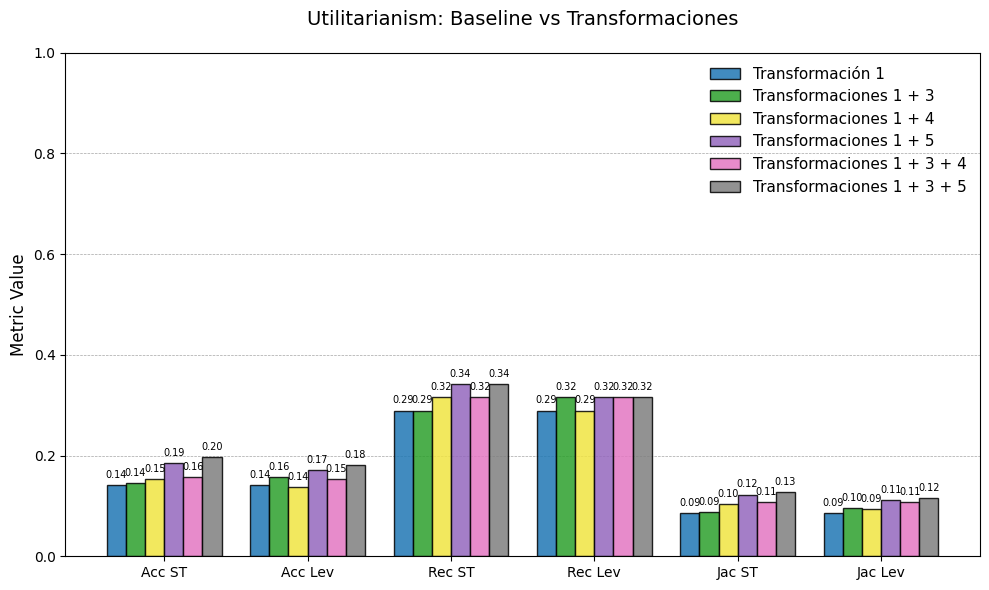

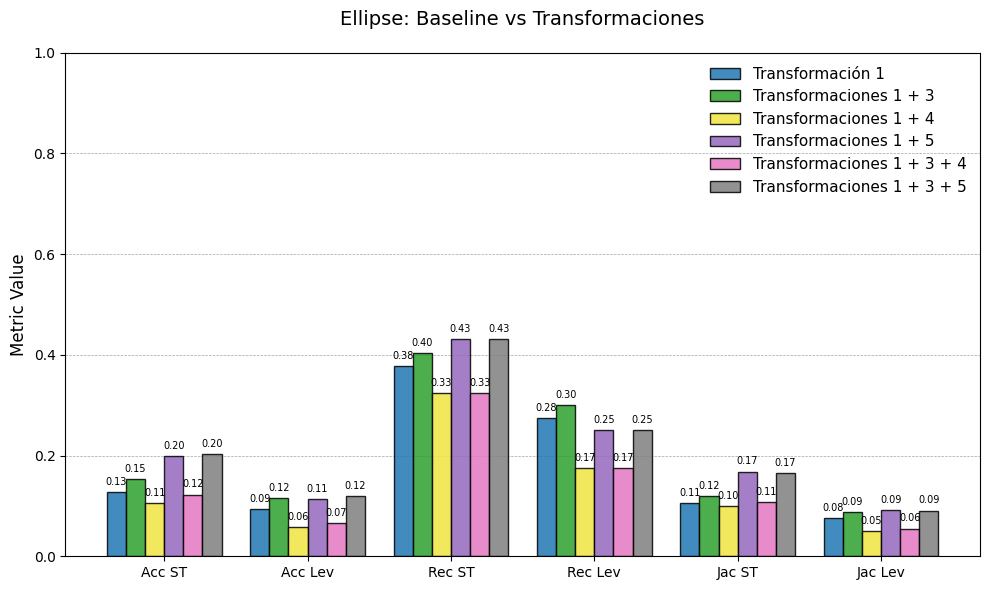

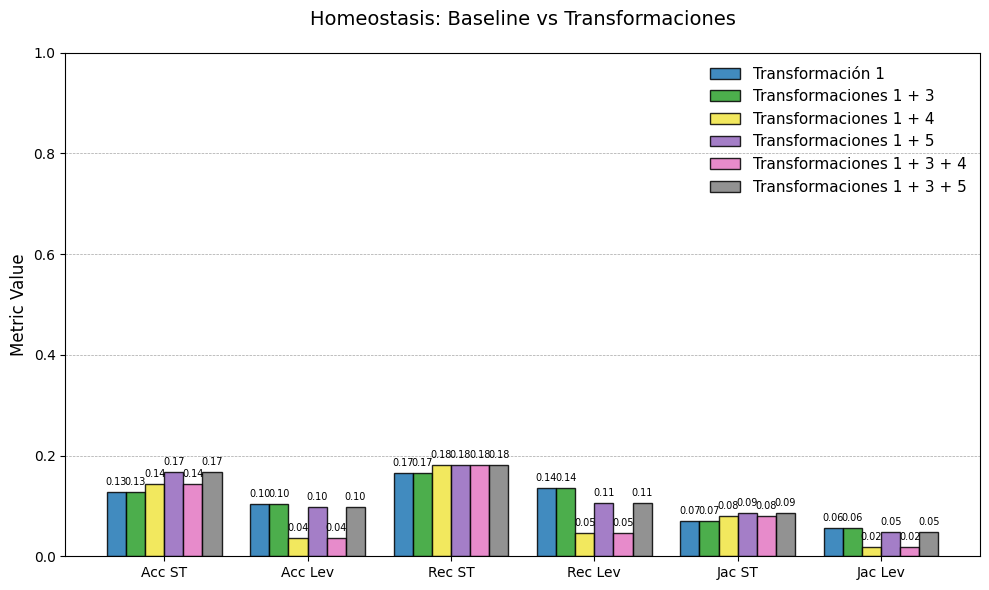

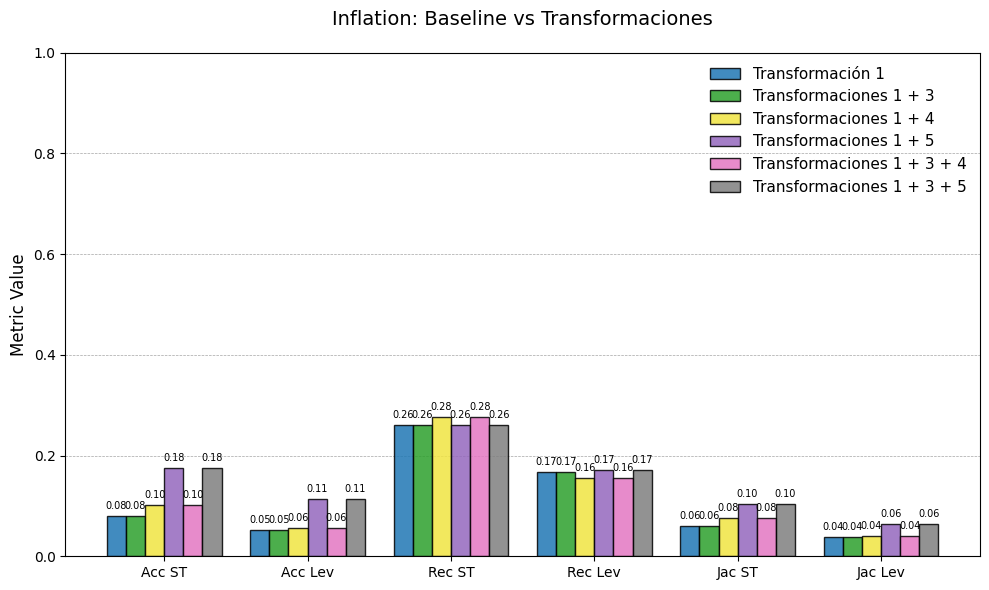

In [119]:
custom_colors = ['#1f77b4', '#2ca02c', '#f0e442', '#9467bd', '#e377c2', '#7f7f7f', '#8c564b']

plot_comparison_bars(df_utilitarianism, "Utilitarianism: Baseline vs Transformaciones", colors=custom_colors)
plot_comparison_bars(df_ellipse, "Ellipse: Baseline vs Transformaciones", colors=custom_colors)
plot_comparison_bars(df_homeostasis, "Homeostasis: Baseline vs Transformaciones", colors=custom_colors)
plot_comparison_bars(df_inflation, "Inflation: Baseline vs Transformaciones", colors=custom_colors)

#### Evolución media de métricas

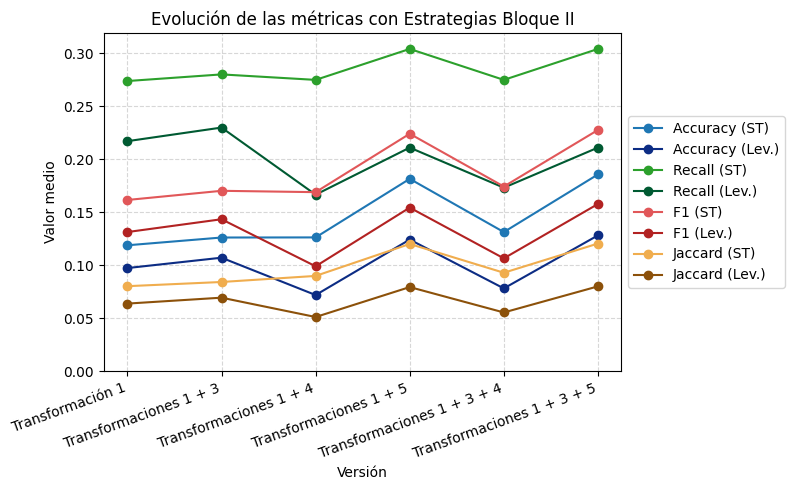

In [120]:
df_all = pd.concat([
    df_utilitarianism.assign(texto="Utilitarianism"),
    df_ellipse.assign(texto="Ellipse"),
    df_homeostasis.assign(texto="Homeostasis"),
    df_inflation.assign(texto="Inflation"),
], ignore_index=True)

df_summary = df_all.groupby("versión")[
["accuracy_ST","accuracy_Levenshtein",
     "recall_ST","recall_Levenshtein",
     "f1_ST", "f1_Levenshtein",
     "jaccard_ST","jaccard_Levenshtein"]
].mean().reset_index()

order=['Transformación 1', 'Transformaciones 1 + 3', 'Transformaciones 1 + 4', 'Transformaciones 1 + 5', 'Transformaciones 1 + 3 + 4', 'Transformaciones 1 + 3 + 5']
df_summary=df_summary.set_index('versión').loc[order].reset_index()

metrics = ["accuracy_ST","accuracy_Levenshtein",
     "recall_ST","recall_Levenshtein",
     "f1_ST", "f1_Levenshtein",
     "jaccard_ST","jaccard_Levenshtein"]

labels = [
    "Accuracy (ST)",
    "Accuracy (Lev.)",
    "Recall (ST)",
    "Recall (Lev.)",
    "F1 (ST)",
    "F1 (Lev.)",
    "Jaccard (ST)",
    "Jaccard (Lev.)"
]


max_val = df_summary[metrics].max().max()

plt.figure(figsize=(8, 5))
for m, lbl in zip(metrics, labels):
    plt.plot(df_summary["versión"], df_summary[m], marker="o", label=lbl, color=color_map[m])

plt.ylim(0, max_val * 1.05)
plt.xlabel("Versión")
plt.ylabel("Valor medio")
plt.title("Evolución de las métricas con Estrategias Bloque II")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle="--", alpha=0.5)

plt.xticks(rotation=20, ha='right')

plt.tight_layout()
plt.show()


In [121]:
df_summary

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Transformación 1,0.118827,0.097360,0.273709,0.217001,0.161555,0.131310,0.080267,0.063844
1,Transformaciones 1 + 3,0.126152,0.107119,0.279959,0.229830,0.170195,0.143384,0.084217,0.069430
2,Transformaciones 1 + 4,0.126246,0.071911,0.274788,0.166545,0.168924,0.099011,0.089938,0.051187
3,Transformaciones 1 + 5,0.181475,0.124218,0.303961,0.210931,0.223993,0.154355,0.120080,0.079420
4,Transformaciones 1 + 3 + 4,0.131279,0.078162,0.274788,0.173124,0.174228,0.106493,0.092928,0.055475
5,Transformaciones 1 + 3 + 5,0.185624,0.128168,0.303961,0.210931,0.227548,0.157752,0.120465,0.080088


In [122]:
to_save = {
    'utilitarianism_bloque_II_evaluation.csv': df_utilitarianism,
    'ellipse_bloque_II_evaluation.csv':        df_ellipse,
    'homeostasis_bloque_II_evaluation.csv':    df_homeostasis,
    'inflation_bloque_II_evaluation.csv':      df_inflation,
    'summary_bloque_II_evaluation.csv':        df_summary,
}

for filename, df in to_save.items():
    df.to_csv(filename, index=False)
    print(f"Guardado: {filename}")

Guardado: utilitarianism_bloque_II_evaluation.csv
Guardado: ellipse_bloque_II_evaluation.csv
Guardado: homeostasis_bloque_II_evaluation.csv
Guardado: inflation_bloque_II_evaluation.csv
Guardado: summary_bloque_II_evaluation.csv
